In [1]:
#import datetime
import  pandas as pd 
import  numpy as np
import  matplotlib.pyplot as plt
import  seaborn as sns


from  sklearn.model_selection import   (train_test_split,
                                      #  GridSearchCV,
                                       # RandomizedSearchCV
)

from  sklearn.metrics         import    (roc_auc_score,
                                         f1_score, 
                                         classification_report)

from catboost import CatBoostClassifier
                     
#from scipy.stats import (randint,
#                        uniform)
from phik import phik_matrix
import shap
import warnings
warnings.filterwarnings("ignore") # игнорирование предупреждений

pd.set_option('display.max_colwidth', None) #для полного отображения строки в датафрейме
pd.set_option('display.max_columns',  None) # для отображения макс.количества столбцов
RANDOM_STATE = 42 # переменная для фиксирования случайности

*Примечание: работа выполнена в JupyterLab со встроенным toc, которая входит в виртуальное окружение для всех проектов Яндекс-Практикума. Слева в нем есть вкладка Table of Content. В ней автоматически формируется структура документа в зависимости от Markdown-заголовков.*

# Моделирование класса пользователя

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.  
**Цель:**  
определить класс покупателя на ближайшее время (купит, не купит).   
**Задачи:**  
* Изучить данные.  
* Разработать полезные признаки.
* Создать модель для классификации пользователей.
* Улучшить модель и максимизировать метрику roc_auc.
* Выполнить тестирование.

Данные представлены 5 датасетами.  

**Файл apparel-purchases.csv содержит данные об истории покупок.**   
**Описание данных:**   
* client_id - идентификатор пользователя   
* quantity - количество товаров в заказе  
* price - цена товара   
* category_ids - вложенные категории, к которым относится товар. Нумерация категорий сквозная для всех уровней. Иногда дерево категорий обновляется, поэтому могут меняться вложенности.   
* date - дата покупки   
* message_id - идентификатор сообщения из рассылки   

**Файл apparel-messages.csv содержит данные об истории рекламных рассылок.**   
**Описание данных:**   
* bulk_campaign_id - идентификатор рекламной кампании   
* client_id - идентификатор пользователя    
* message_id - идентификатор сообщений      
* event - тип действия   
* channel - канал рассылки   
* date - дата рассылки   
* created_at - точное время создания сообщения     

**Файл apparel-target_binary.csv содержит данные о классе покупателя.**   
**Описание данных:**   
* client_id - идентификатор пользователя   
* target - целевой признак   

**Файл full_campaign_daily_event.csv - агрегация общей базы рассылок по дням и типам событий.**   
**Описание данных:**   
* date - дата
* bulk_campaign_id - идентификатор рассылки     
* count_event* - общее количество каждого события event
* nunique_event* - количество уникальных client_id в каждом событии      

**Файл full_campaign_daily_event_channel.csv - агрегация по дням с учетом событий и каналов рассылки.**   
**Описание данных:**   
* date - дата   
* bulk_campaign_id - идентификатор рассылки  
* count_event*_channel* - общее количество каждого события по каналам
* nunique_event* - количество уникальных client_id по событиям и каналам   

## Знакомство с данными

### Считывание данных из файлов

In [2]:
%%time
purchases = pd.read_csv('./filtered_data/apparel-purchases.csv')
messages =  pd.read_csv('./filtered_data/apparel-messages.csv')
target = pd.read_csv('./filtered_data/apparel-target_binary.csv')
event = pd.read_csv('./filtered_data/full_campaign_daily_event.csv')
event_channel = pd.read_csv('./filtered_data/full_campaign_daily_event_channel.csv')

CPU times: total: 11.3 s
Wall time: 12 s


### Общая информация

#### Датафрейм "purchases"

**Выведем первые 5 строчек датафрейма `purchases` и общую информацию о нем.**

In [3]:
# функция выводит первые 5 строк датафрейма, общую информацию и описат.статистики
def func_info(data):
    display(data.head())
    display(data.describe())
    data.info()

In [4]:
func_info(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


**Вывод:**  
* **В датафрейме `purchases` нет пропущенных значений.**
* **В таблице содержится 202208 строк (от 0 до 202207) - данные о покупках по дням и товарам.**
* **В таблице содержится 6 столбцов. Наименования столбцов в змеином стиле, соответствуют общепринятому стандарту.**
* **Типы данных в колонке с датой (date) надо привести к формату с датой.**
* **Вес датафрейма: 9.3+ Мб.**

#### Датафрейм "messages"

**Выведем первые 5 строчек датафрейма `messages` и общую информацию о нем.**

In [5]:
func_info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,1.329704e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [6]:
messages.isna().sum().sum()

0

**Вывод:**  
* **В датафрейме `messages` нет пропущенных значений.**
* **В таблице содержится 12739798 строк (от 0 до 12739797) - данные о рассылках клиентам из таблицы покупок.**
* **В таблице содержится 7 столбцов. Наименования столбцов в змеином стиле, соответствуют общепринятому стандарту.**
* **Типы данных в колонках с датой (date, created_at) надо привести к формату с датой.**
* **Вес датафрейма: 680.4+ Мб.**

#### Датафрейм "target"

**Выведем первые 5 строчек датафрейма `target` и общую информацию о нем.**

In [7]:
func_info(target)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


**Вывод:**  
* **В датафрейме `target` нет пропущенных значений.**
* **В таблице содержится 49849 строк (от 0 до 49848) - данные о классе пользователя.**
* **В таблице содержится 2 столбца. Наименования столбцов в змеином стиле, соответствуют общепринятому стандарту.**
* **Вес датафрейма: 779 Кб.**

#### Датафрейм "event"

**Выведем первые 5 строчек датафрейма `event` и общую информацию о нем.**

In [8]:
func_info(event)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,74.276016,0.921326,77.398689,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,1004.271405,29.715170,1913.395511,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,75899.000000,5043.000000,287341.000000,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

**Вывод:**  
* **В датафрейме `event` нет пропущенных значений.**
* **В таблице содержится 131072 строк (от 0 до 131071) - агрегация общей базы рассылок по дням и типам событий.**
* **В таблице содержится 24 столбца. Наименования столбцов в змеином стиле, соответствуют общепринятому стандарту.**
* **Вес датафрейма: 24.0+ Мб.**

#### Датафрейм "event_channel"

**Выведем первые 5 строчек датафрейма `event_channel` и общую информацию о нем.**

In [9]:
func_info(event_channel)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,31.396263,42.879753,4.116615e+02,3.271339e+03,0.287712,0.177391,24.262146,0.134125,5.960602,59.483444,7.444562e+03,58.863007,7.350267e+03,18.989990,0.810364,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,562.883309,833.316257,9.519713e+03,6.188001e+04,6.484979,2.971908,724.270910,1.976439,73.284148,1371.955350,1.393509e+05,1357.271261,1.355799e+05,1402.414107,183.298579,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,45718.000000,75899.000000,2.548617e+06,2.922440e+06,779.000000,359.000000,76281.000000,177.000000,8299.000000,165526.000000,1.154351e+07,165526.000000,6.636578e+06,287404.000000,63920.000000,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

**Вывод:**  
* **В датафрейме `event_channel` нет пропущенных значений.**
* **В таблице содержится 131072 строк (от 0 до 131071) - агрегация по дням с учетом событий и каналов рассылки.**
* **В таблице содержится 36 столбцов. Наименования столбцов в змеином стиле, соответствуют общепринятому стандарту.**
* **Вес датафрейма: 36.0+ Мб.**

## Предобработка данных

### Изменение типов данных

In [10]:
purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')
event['date'] = pd.to_datetime(event['date'], format='%Y-%m-%d')
event_channel['date'] = pd.to_datetime(event_channel['date'], format='%Y-%m-%d')

In [11]:
messages['date'].min(), messages['date'].max()

(Timestamp('2022-05-19 00:00:00'), Timestamp('2024-02-15 00:00:00'))

In [12]:
purchases['date'].min(), purchases['date'].max()

(Timestamp('2022-05-16 00:00:00'), Timestamp('2024-02-16 00:00:00'))

In [13]:
messages.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


### Поиск дубликатов

In [14]:
messages.duplicated().sum()

48610

**Удалим дубликаты, так как совпадение полное и по дате и по времени.**

In [15]:
messages = messages.drop_duplicates()

In [16]:
event.duplicated().sum()

0

In [17]:
event_channel.duplicated().sum()

0

In [18]:
target.duplicated().sum()

0

In [19]:
purchases.duplicated().sum()

73020

**В датафрейме purchases нет столбца со временем покупки, поэтому на основе одной даты можно быть не уверенным, что это дубликат. Посмотрим подробнее.**

In [20]:
purchases[purchases.duplicated()]['price'].max()

48299.0

In [21]:
purchases[purchases.duplicated()].query('price==48299')

,client_id,quantity,price,category_ids,date,message_id
198463,1515915625995288129,1,48299.0,"['4', '29', '310', '1577']",2024-01-31,1515915625995288129-14553-65b65deea7556


In [22]:
purchases.query('price==48299 and client_id==1515915625995288129')

,client_id,quantity,price,category_ids,date,message_id
198462,1515915625995288129,1,48299.0,"['4', '29', '310', '1577']",2024-01-31,1515915625995288129-14553-65b65deea7556
198463,1515915625995288129,1,48299.0,"['4', '29', '310', '1577']",2024-01-31,1515915625995288129-14553-65b65deea7556


In [23]:
purchases[purchases['category_ids'] =="['4', '29', '310', '1577']"]['quantity'].max()

1

In [24]:
purchases[purchases['category_ids'] =="['4', '29', '310', '1577']"]['price'].min(),\
purchases[purchases['category_ids'] =="['4', '29', '310', '1577']"]['price'].max()

(1.0, 63499.0)

In [25]:
purchases[purchases['category_ids'] =="['4', '29', '310', '1577']"].query('price==1')

,client_id,quantity,price,category_ids,date,message_id
100614,1515915625625548006,1,1.0,"['4', '29', '310', '1577']",2023-04-09,1515915625625548006-11668-6431245b5a2da
100615,1515915625625548006,1,1.0,"['4', '29', '310', '1577']",2023-04-09,1515915625625548006-11668-6431245b5a2da


**Удалим дубликаты из purchases. Несмотря на отсутствие времени покупки, судя по ценам покупки, можно предположить, что это дубликаты. Вывод основывается на одинаковых строках с покупками при достаточно высоких ценах.**

In [26]:
purchases = purchases.drop_duplicates()

In [27]:
purchases.shape

(129188, 6)

In [28]:
purchases.duplicated(subset=['client_id', 'category_ids', 'date']).sum()

32399

In [29]:
purchases.sort_values(by='price').duplicated(subset=['client_id', 'category_ids', 'date']).sum()

32399

In [30]:
# пример неполного дубликата по клиенту, товару, дате
purchases.sort_index(ascending=False)[purchases['category_ids']=="['4', '28', '244', '432']"].query('client_id==1515915626009802894')

,client_id,quantity,price,category_ids,date,message_id
202193,1515915626009802894,1,768.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202192,1515915626009802894,1,999.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202191,1515915626009802894,1,461.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202190,1515915626009802894,1,599.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c


In [31]:
# пример неполного дубликата по клиенту, товару, дате
purchases.sort_values(by='price')[purchases['category_ids']=="['4', '28', '244', '432']"].query('client_id==1515915626009802894')

,client_id,quantity,price,category_ids,date,message_id
202191,1515915626009802894,1,461.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202190,1515915626009802894,1,599.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202193,1515915626009802894,1,768.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202192,1515915626009802894,1,999.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c


У нас в таблице один и тот же клиент заказывает в один и тот же день одинаковый товар, но по разным ценам. Вероятно, в итоге клиент остальные заказы удаляет и покупает только товар с меньшей ценой. Удалим дубликаты по клиенту, товару и дате, оставив только товары с меньшей ценой. Хотя это необязательно, можно оставить товар, ориентируясь на индекс, то есть оставлять товар, ориентируясь на последний номер индекса. Хотя здесь тоже можно быть не уверенным, мы же не знаем, как формировалась база. (но можно проверить оба варианта)

In [32]:
purchases = purchases.sort_values(by=['client_id','category_ids','price']).drop_duplicates(keep='first', subset=['client_id', 'category_ids', 'date'])

#purchases = purchases.sort_index(ascending=False).drop_duplicates(keep='first', subset=['client_id', 'category_ids', 'date'])

In [33]:
purchases.shape

(96789, 6)

В результате для приведенного выше примера останется только товар с меньшей ценой.

In [34]:
purchases[purchases['category_ids']=="['4', '28', '244', '432']"].query('client_id==1515915626009802894')

,client_id,quantity,price,category_ids,date,message_id
202191,1515915626009802894,1,461.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c


### Поиск аномалий

Столбец message_id состоит из 3 частей.Первая часть это client_id, 2 часть - bulk_campaign_id из таблицы messages. 

Создадим 3 дополнительных столбца.

In [35]:
purchases['client_id_double'] = purchases['message_id'].str.split('-').str[0].astype('int64')
purchases['campaign_id_double'] = purchases['message_id'].str.split('-').str[1]#.astype('int64')
purchases['message_id_3'] = purchases['message_id'].str.split('-').str[2]

Проверим на соответствие. 

In [36]:
purchases['client_id'].nunique()

49849

In [37]:
purchases[purchases['client_id_double']==purchases['client_id']]['client_id'].nunique()

37771

Есть несоответствующие строки. Вероятно, эти строки как-то неправильно были присоединены к датафрейму с покупками.  client_id и client_id_double совпадают для 37771 клиентов из 49849.

In [38]:
target['client_id'].nunique()

49849

In [39]:
set(purchases['client_id']) == set(target['client_id'])

True

**Не будем удалять строки, в которых есть несоответствующие данные по message_id, иначе мы потеряем информацию по размеченным клиентам.** Просто будем иметь ввиду, что колонка message_id может содержать некорректную информацию.

**Создадим вспомогательную колонку, где 0 - не совпадают id клиентов, 1 - совпадают.**

In [40]:
#удалим вспомогательную колонку
purchases['match_client_id'] = (purchases['client_id_double'] == purchases['client_id']) * 1
purchases['match_client_id'].sample(3)

62553     0
23089     1
112264    0
Name: match_client_id, dtype: int32

Посмотрим на графики по числовым колонкам в датафрейме purchases.

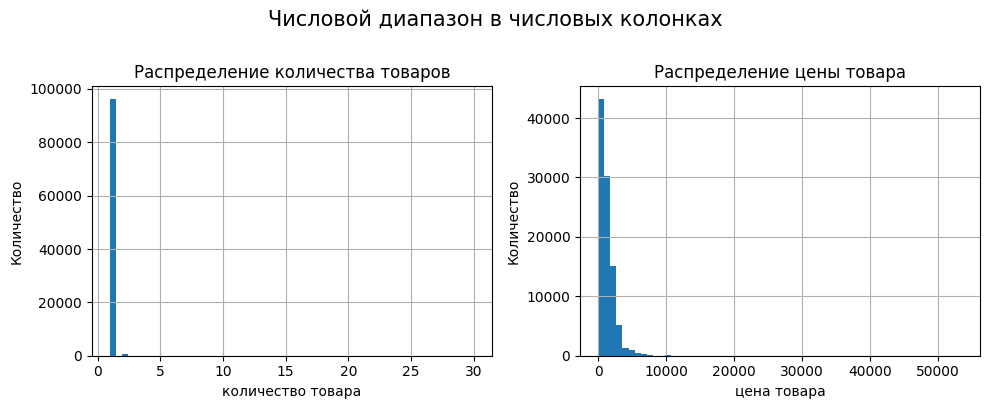

In [41]:
# строим гистограммы в числовых колонках
axes = purchases[['quantity', 'price']].hist(figsize=(10,4), bins=60);

# Общий заголовок для всех колонок
plt.suptitle('Числовой диапазон в числовых колонках', fontsize=15, y=1.01);
# списки для заголовков и подписей осей
titles = [
    'Распределение количества товаров', 
    'Распределение цены товара',
    ]
xlabel = [
    'количество товара',
    'цена товара',
    ]
ylabel = ['Количество']*2
"""
axes - массив numpy.ndarray размером (1,2)
axes.flat - это аттрибут numpy.ndarray,  одномерный итератор по массиву,
используется для перебора всех осей из массива осей (в нашем случае осей (1,2))
Это позволяет использовать 1 цикл.
Альтернатива - axes.flatten(), где flatten() - метод массива numpy. Вместо
итератора возвращает уменьшенную версию массива. Снаружи между ними нет никакой разницы.
Однако итератор фактически не создает новый массив и может быть немного быстрее.
"""
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i]);
    ax.set_xlabel(xlabel[i]);
    ax.set_ylabel(ylabel[i]);

# чтобы оси не пересекались с соседними графиками
plt.tight_layout();

In [42]:
purchases[(purchases['quantity']>5 )&(purchases['price']>100 )]

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id
170917,1515915625491750075,6,299.0,"['6060', '6058', '6067', '5498']",2023-09-25,1515915625491750075-13855-650d4d42804ed,1515915625491750075,13855,650d4d42804ed,1
128134,1515915625797455244,6,199.0,"['6060', '6058', '6067', '5498']",2023-06-03,1515915625797455244-13076-6479c39e7662b,1515915625797455244,13076,6479c39e7662b,1


**Видим, что товары, купленные в большом количестве, соответствуют низким ценам.**   
Аномалий не найдено.

### Обработка идентификаторов категорий товаров

In [43]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1
3697,1515915625468060902,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1
3701,1515915625468060902,1,999.0,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1
3696,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1
3700,1515915625468060902,1,299.0,"['4', '28', '290', '422']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1


Вычислим максимальную глубину вложенности дерева категорий.

In [44]:
# максимальная глубина вложенности
purchases['category_ids'].str.count(",").max()+1

5

In [45]:
purchases['category_ids'].str.count(",").min()

0

In [46]:
purchases[purchases['category_ids'].str.count(",")==0].head()

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id
95806,1515915625468061170,1,7.0,[],2023-03-26,1515915625468061170-11144-641ad2cda77a2,1515915625468061170,11144,641ad2cda77a2,1
70997,1515915625468066318,1,7.0,[],2022-12-21,1515915625468066318-8793-63a0585fc071d,1515915625468066318,8793,63a0585fc071d,1
163839,1515915625468068308,1,7.0,[],2023-08-14,1515915625468068308-13647-64d9f80751dd6,1515915625468068308,13647,64d9f80751dd6,1
109882,1515915625468068447,1,10.0,[],2023-04-28,1515915625468068447-12252-644bc940a95ec,1515915625468068447,12252,644bc940a95ec,1
107506,1515915625468068690,1,1.0,[],2023-04-19,1515915625468068690-11760-643673935a680,1515915625468068690,11760,643673935a680,1


In [47]:
purchases[purchases['category_ids'].str.count(",")==0].shape[0]

3196

In [48]:
purchases[purchases['category_ids'].str.count(",")==0]['category_ids'].unique()

array(['[]', '[None]'], dtype=object)

In [49]:
purchases[purchases['category_ids']=="[]"].shape[0]

2599

In [50]:
purchases[purchases['category_ids']=="[None]"].shape[0]

597

**Вложенность из 1 корневой категории отсутствует.** 

**Таким образом, в датафрейме есть 3196 строк с пропусками по категориям товаров, которые в исходном датафрейме представлены заглушками 2 видов: '[]', '[None]'.**

In [51]:
purchases[purchases['category_ids'].str.count(",")==1].shape[0]

0

**Т.о. вложенность из 2 категорий отсутствует.**

In [52]:
purchases[purchases['category_ids'].str.count(",")==2].shape[0]

543

**543 строки с вложенностью = 3.**

In [53]:
purchases[purchases['category_ids'].str.count(",")==2]

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id
77602,1515915625468078544,1,174.0,"['4', '44', '428']",2022-12-24,1515915625468078544-8995-63a5b12244e4b,1515915625468078544,8995,63a5b12244e4b,1
115038,1515915625468083376,1,209.0,"['4', '44', '428']",2023-04-30,1515915625468083376-12218-644b83904c598,1515915625468083376,12218,644b83904c598,1
170990,1515915625468091813,1,55.0,"['4', '44', '489']",2023-09-26,1515915625468091813-13864-651141a531bb2,1515915625468091813,13864,651141a531bb2,1
168359,1515915625468102493,1,174.0,"['4', '44', '428']",2023-09-09,1515915625468102493-3401-623044455acaf,1515915625468102493,3401,623044455acaf,1
83528,1515915625468104870,1,71.0,"['4', '44', '491']",2023-01-21,1515915625468104870-9341-63c1189ace2f5,1515915625468104870,9341,63c1189ace2f5,1
...,...,...,...,...,...,...,...,...,...,...
195322,1515915626007311047,1,35.0,"['4', '44', '1571']",2024-01-17,1515915626007311047-14424-65966d37271cf,1515915626007311047,14424,65966d37271cf,1
195830,1515915626008163512,1,97.0,"['4', '44', '428']",2024-01-19,1515915626008163512-14499-65a9131c18577,1515915626008163512,14499,65a9131c18577,1
195832,1515915626008163512,1,116.0,"['4', '44', '989']",2024-01-19,1515915626008163512-14499-65a9131c18577,1515915626008163512,14499,65a9131c18577,1
198359,1515915626008924519,1,316.0,"['4', '44', '490']",2024-01-30,1515915625815783436-14546-65b39dc8ed15f,1515915625815783436,14546,65b39dc8ed15f,0


In [54]:
purchases[purchases['category_ids'].str.count(",")==2]['category_ids'].nunique()

22

In [55]:
purchases[purchases['category_ids'].str.count(",")==2]['category_ids'].unique()

array(["['4', '44', '428']", "['4', '44', '489']", "['4', '44', '491']",
       "['4', '44', '501']", "['4', '44', '1594']", "['4', '44', '1564']",
       "['4', '44', '490']", "['4', '44', '1571']", "['4', '44', '1381']",
       "['4', '44', '528']", "['4', '44', '1097']",
       "['4', '1822', '499']", "['4', '44', '430']", "['4', '44', '549']",
       "['4', '44', '493']", "['4', '44', '494']", "['4', '44', '989']",
       "['4', '29', '503']", "['4', '44', '492']", "['4', '30', '503']",
       "['4', '44', '1600']", "['5562', '5597', '5782']"], dtype=object)

**Уникальных 22 категории из 3 уровней вложенности, 543 строки.** Это наталкивает на мысль объединить первые 3 категории для всех уровней вложенности и посмотреть, что получится, так как минимальная градация начинается с 3 категорий.

In [56]:
purchases[purchases['category_ids'].str.count(",")==3].shape[0]

92780

In [57]:
purchases[purchases['category_ids'].str.count(",")==3]['category_ids'].nunique()

908

**92780 строк с вложенностью = 4, уникальных 908 значений.**

In [58]:
purchases[purchases['category_ids'].str.count(",")==4].shape[0]

270

In [59]:
purchases[purchases['category_ids'].str.count(",")==4].head()

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id
107500,1515915625468068690,1,727.0,"['2', '17', '330', '387', '467']",2023-04-19,1515915625468068690-11760-643673935a680,1515915625468068690,11760,643673935a680,1
85485,1515915625468069976,1,799.0,"['2', '17', '330', '387', '467']",2023-02-20,1515915625468069976-10289-63f35aa565818,1515915625468069976,10289,63f35aa565818,1
11254,1515915625468070311,1,1199.0,"['2', '17', '330', '387', '467']",2022-06-05,1515915625468070311-4744-629b4019082a7,1515915625468070311,4744,629b4019082a7,1
154535,1515915625468072367,1,848.0,"['2', '17', '330', '387', '467']",2023-07-07,1515915625468072367-10289-63f35aab3db61,1515915625468072367,10289,63f35aab3db61,1
168682,1515915625468095005,1,2199.0,"['2', '17', '330', '387', '467']",2023-09-10,1515915625468095005-13779-64fac576153b5,1515915625468095005,13779,64fac576153b5,1


In [60]:
purchases[purchases['category_ids'].str.count(",")==4]['category_ids'].nunique()

1

**270 строк с вложенностью = 5, при этом всего одна уникальная комбинация. Это наталкивает на мысль, что это может быть случайность, то есть где-то здесь закралась ошибка, одна подкатегория какого-то уровня вбита как две, например, '2', '17' - ошибка, должно быть '217'. Исследуем это далее.**

In [61]:
purchases['category_ids'].nunique()

933

**Всего количество уникальных категорий с различным уровнем вложенности - 933 (количество ветвей из 3 подкатегорий, 4 подкатегорий и 5 подкатегорий).**

**Создадим столбцы с подкатегориями от 1 до 5.**

In [62]:
# функция создает столбец с уровнем категории
def func_level_cat(num):
    col_name = 'category_ids_' + str(num)
    purchases[col_name] = (purchases['category_ids'].str.strip('[]').str.split(',').str[num-1]).str.strip(" ''")
    return purchases[col_name]

In [63]:
func_level_cat(1)
func_level_cat(2)
func_level_cat(3)
func_level_cat(4)
func_level_cat(5)

3695      NaN
3697      NaN
3701      NaN
3696      NaN
3700      NaN
         ... 
202198    NaN
201563    NaN
202204    NaN
202206    NaN
202207    NaN
Name: category_ids_5, Length: 96789, dtype: object

In [64]:
purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id,category_ids_1,category_ids_2,category_ids_3,category_ids_4,category_ids_5
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,176,458,NaN
3697,1515915625468060902,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,1828,1599,NaN
3701,1515915625468060902,1,999.0,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,28,244,432,NaN


In [65]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96789 entries, 3695 to 202207
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           96789 non-null  int64         
 1   quantity            96789 non-null  int64         
 2   price               96789 non-null  float64       
 3   category_ids        96789 non-null  object        
 4   date                96789 non-null  datetime64[ns]
 5   message_id          96789 non-null  object        
 6   client_id_double    96789 non-null  int64         
 7   campaign_id_double  96789 non-null  object        
 8   message_id_3        96789 non-null  object        
 9   match_client_id     96789 non-null  int32         
 10  category_ids_1      96789 non-null  object        
 11  category_ids_2      93593 non-null  object        
 12  category_ids_3      93593 non-null  object        
 13  category_ids_4      93050 non-null  object

In [66]:
purchases['category_ids_1'].nunique()

10

In [67]:
purchases['category_ids_1'].unique()

array(['4', '2', '', '5562', '6060', '5963', 'None', '1', '5', '3'],
      dtype=object)

**# Заменим строки с заглушками '', 'None' на ''.**

In [68]:
purchases['category_ids_1'] = purchases['category_ids_1'].apply(lambda x: '' if x=='None' else x)
purchases['category_ids_1'].unique()

array(['4', '2', '', '5562', '6060', '5963', '1', '5', '3'], dtype=object)

In [69]:
purchases = purchases.fillna('')
purchases.isna().sum().sum()

0

**На первом уровне 9 уникальных категорий с учетом заполнения пропусков заглушкой ''.**  
**Категории обработаны.**

In [70]:
purchases['category_ids_1'].value_counts()

4       54962
5562    21164
2       14017
         3196
6060     2800
5963      640
3           6
1           3
5           1
Name: category_ids_1, dtype: int64

**Есть мелкие категории в подкатегории 1 уровня.**

In [71]:
"""
Функция соединяет в одну число подкатегории для заданных подкатегорий,
то есть можно соединить 1 и 2 подкатегории, 1,2,3 или 1,2,3,4 или 1,2,3,4,5 или 1,3 или 1,4
lst - список из категорий
Например, перечисляем 2, 3 или 4 элемента, которые являются столбцами 'category_ids_1',
'category_ids_2', 'category_ids_3', 'category_ids_4', 'category_ids_5'.
Пример вызова: обязательно задаем список lst, размерность которого может меняться.
lst = ['category_ids_1', 'category_ids_2']
purchases.apply(func_level_cat_concat, axis=1)
"""
def func_level_cat_concat(row):
    rez=''
    for i in range(len(lst)):
        rez += row[lst[i]]
    return rez
    

In [72]:
lst=['category_ids_1', 'category_ids_2']
purchases['category_ids_1_2'] = purchases.apply(func_level_cat_concat, axis=1)

In [73]:
lst=['category_ids_1', 'category_ids_2', 'category_ids_3']
purchases['category_ids_1_2_3'] = purchases.apply(func_level_cat_concat, axis=1)

In [74]:
lst=['category_ids_1', 'category_ids_2', 'category_ids_3', 'category_ids_4']
purchases['category_ids_1_2_3_4'] = purchases.apply(func_level_cat_concat, axis=1)

In [75]:
lst=['category_ids_1', 'category_ids_2', 'category_ids_3', 'category_ids_4', 'category_ids_5']
purchases['category_ids_1_2_3_4_5'] = purchases.apply(func_level_cat_concat, axis=1)

In [76]:
print('Уникальных комбинаций 1 уровня:', purchases['category_ids_1'].nunique())
print('Уникальных комбинаций 1 и 2 уровня:', purchases['category_ids_1_2'].nunique())
print('Уникальных комбинаций 1, 2, 3 уровня:', purchases['category_ids_1_2_3'].nunique())
print('Уникальных комбинаций 1, 2, 3, 4 уровня:', purchases['category_ids_1_2_3_4'].nunique())
print('Уникальных комбинаций 1, 2, 3, 4, 5 уровня:', purchases['category_ids_1_2_3_4_5'].nunique())

Уникальных комбинаций 1 уровня: 9
Уникальных комбинаций 1 и 2 уровня: 32
Уникальных комбинаций 1, 2, 3 уровня: 295
Уникальных комбинаций 1, 2, 3, 4 уровня: 932
Уникальных комбинаций 1, 2, 3, 4, 5 уровня: 932


In [77]:
print('Уникальные комбинации 5 уровня:', purchases['category_ids_5'].unique())

Уникальные комбинации 5 уровня: ['' '467']


In [78]:
purchases[purchases['category_ids'].str.count(",")==4]['category_ids'].unique()

array(["['2', '17', '330', '387', '467']"], dtype=object)

**Таким образом, на 4 и 5 уровне мы получаем одинаковое количество категорий, хотя мы знаем, что на 4 уровне 932 уникальные комбинации, а на 5 уровне - 1 уникальная комбинация (без заглушки). Это говорит о том, что 5 уровня, вероятно, нет, он появился случайно - в результате ошибки: категорию '217' ошибочно вбили как 2 подкатегории '2', '17'.**

**Таким образом, у нас 9 уникальных категорий (вместе с заглушкой) для 1 уровня, 32 уникальные категории для 2 уровня, 295 уникальных категорий для 3 уровня и 932 уникальные категории для самого глубокого уровня.**

**Посмотрим на уникальные категории для первого уровня и для первых двух уровней.**

In [79]:
purchases['category_ids_1'].unique()

array(['4', '2', '', '5562', '6060', '5963', '1', '5', '3'], dtype=object)

In [80]:
purchases['category_ids_1_2'].unique()

array(['427', '428', '218', '', '55625630', '45837', '55625631',
       '60606058', '60606059', '55625633', '429', '431', '217',
       '55625589', '55625597', '55625536', '41822', '55625558',
       '55625632', '59635959', '55625634', '55625683', '60606057', '444',
       '55625697', '55625599', '430', '122', '510', '314', '312', '18'],
      dtype=object)

Таким образом , так как для пяти категорий только одно уникальное значение, и мы выяснили, что при объединении дерева из 4 подкатегорий и дерева из пяти подкатегорий, количество уникальных товаров одно и тоже - 932, значит 5 категория, вероятно, - случайность. Она образовалась случайно. 

In [81]:
purchases.select_dtypes(include='object').describe()

,category_ids,message_id,campaign_id_double,message_id_3,category_ids_1,category_ids_2,category_ids_3,category_ids_4,category_ids_5,category_ids_1_2,category_ids_1_2_3,category_ids_1_2_3_4,category_ids_1_2_3_4_5
count,96789,96789,96789,96789,96789,96789,96789,96789,96789,96789,96789,96789,96789
unique,933,50175,1551,50175,9,32,292,839,2,32,295,932,932
top,"['4', '28', '57', '431']",1515915625489095763-6251-6311b13a4cf78,4679,6311b13a4cf78,4,28,57,431,,428,42857,42857431,42857431
freq,4566,168,3149,168,54962,40751,4566,4566,96519,40751,4566,4566,4566


**Видим, что на первых двух подуровнях чаще встречается комбинация 428 (объединение 4 и 28), она встречается 40751 раз.**

In [82]:
purchases['message_id_3'].value_counts()[:16]

6311b13a4cf78    168
6398316793f51     38
636dfea7ca890     33
639b2f0ad5e2e     32
648319c8bb592     26
63f35ab5784a4     26
623044455acaf     25
649d48a8137ce     24
644b8248771bb     24
64cd08c473b82     24
65cb24729da23     23
65731187ed2e2     22
636e58f517797     22
647eb69140453     20
636df3386d265     20
643902d6271e5     20
Name: message_id_3, dtype: int64

## Извлечение дополнительной информации

### Создание столбца с общей суммой

**Создадим столбец с общей суммой (цена * количество).**

In [83]:
purchases['total'] = purchases['quantity'] * purchases['price']

In [84]:
purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id,category_ids_1,category_ids_2,category_ids_3,category_ids_4,category_ids_5,category_ids_1_2,category_ids_1_2_3,category_ids_1_2_3_4,category_ids_1_2_3_4_5,total
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,176,458,,427,427176,427176458,427176458,199.0
3697,1515915625468060902,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,1828,1599,,427,4271828,42718281599,42718281599,1299.0
3701,1515915625468060902,1,999.0,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,28,244,432,,428,428244,428244432,428244432,999.0


### Создание колонок с годом, месяцем, днем недели

In [85]:
purchases['year'] = purchases.date.dt.year

In [86]:
purchases['month'] = purchases.date.dt.month

In [87]:
purchases['dayofweek'] = purchases.date.dt.dayofweek

## Исследовательский анализ

**Посмотрим на целевой признак.**

In [88]:
target['target'].value_counts(normalize=True)

0    0.980722
1    0.019278
Name: target, dtype: float64

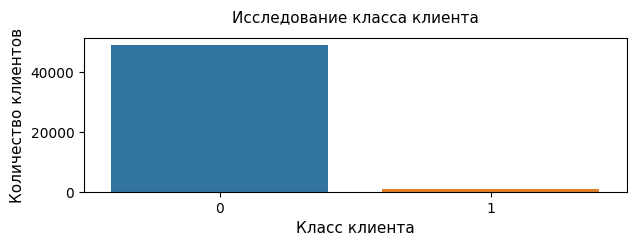

In [89]:
plt.figure(figsize=(7,2))
sns.countplot(data=target, x='target');
# названия осей
plt.xlabel('Класс клиента', fontsize=11);
plt.ylabel('Количество клиентов', fontsize=11);
# заголовок
plt.title('Исследование класса клиента', y=1.05, fontsize=11);

**Видим, что данные не сбалансированы: совершили покупку - 2%, не совершили покупку - 98%.**

**Исследуем данные в разрезе целевого признака.**    
Для этого без группировки добавим в датафреймы purchases и messages целевой признак. (при моделировании будем группировать данные по клиентам).

In [90]:
temp1 = purchases.set_index('client_id').join(target.set_index('client_id'))
display(temp1.head(3))
temp1.shape

,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id,category_ids_1,category_ids_2,category_ids_3,category_ids_4,category_ids_5,category_ids_1_2,category_ids_1_2_3,category_ids_1_2_3_4,category_ids_1_2_3_4_5,total,year,month,dayofweek,target
client_id,,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,176,458,,427,427176,427176458,427176458,199.0,2022,5,4,0
1515915625468060902,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,1828,1599,,427,4271828,42718281599,42718281599,1299.0,2022,5,4,0
1515915625468060902,1,999.0,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,28,244,432,,428,428244,428244432,428244432,999.0,2022,5,4,0


(96789, 23)

**Исследуем влияние месяца на сумму покупки.**

In [91]:
temp1.groupby('month')['total'].agg(['count', 'median', 'mean', 'sum'])#.sort_values('sum')

,count,median,mean,sum
month,,,,
1,4210,999.0,1320.879335,5560902.0
2,2512,759.5,1179.350318,2962528.0
3,5003,1119.0,1359.613432,6802146.0
4,7144,1049.0,1177.514138,8412161.0
5,7815,1120.0,1315.766219,10282713.0
6,20625,996.0,1175.037333,24235145.0
7,11408,999.0,1217.213710,13885974.0
8,8242,1123.0,1375.202499,11334419.0
9,4770,1285.5,1413.172956,6740835.0


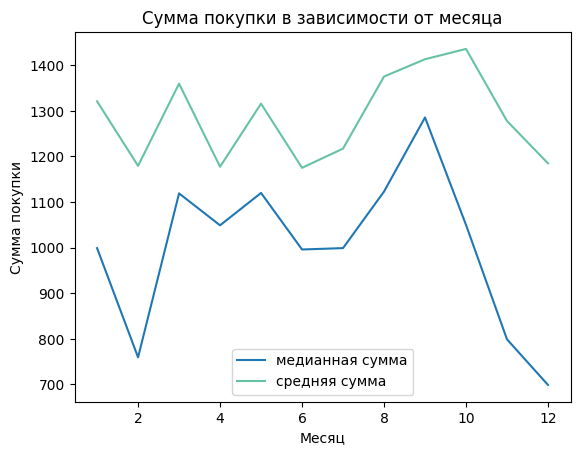

In [92]:
temp1.groupby('month')['total'].median().plot()
temp1.groupby('month')['total'].mean().plot(colormap = 'Set2')
plt.title('Сумма покупки в зависимости от месяца');
plt.ylabel('Сумма покупки')
plt.xlabel('Месяц');
plt.legend(['медианная сумма','средняя сумма']);

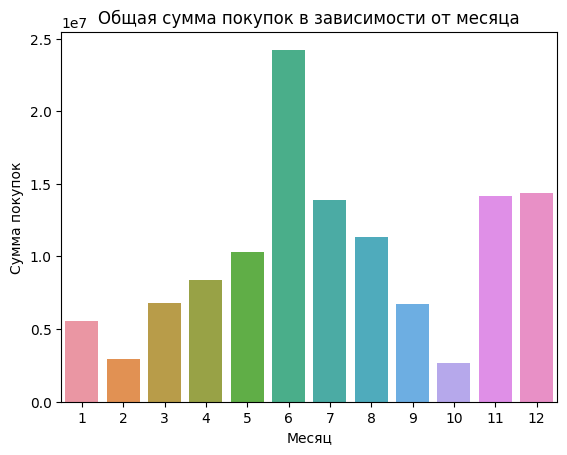

In [93]:
sns.barplot(x='month', y='total', data=temp1, estimator=np.sum, ci=None)
plt.title('Общая сумма покупок в зависимости от месяца');
plt.ylabel('Сумма покупок');
plt.xlabel('Месяц');

**Исследуем влияние дня недели на сумму покупок.**

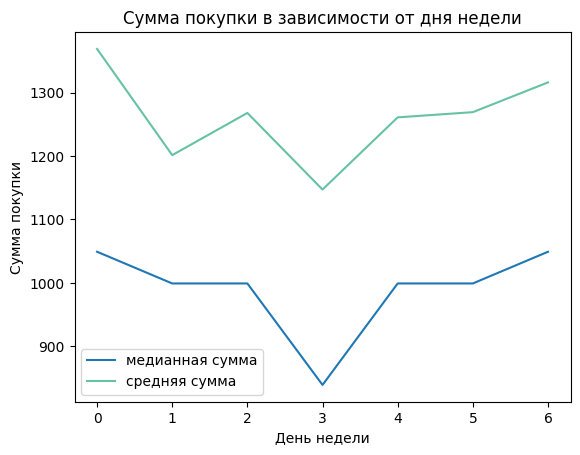

In [94]:
temp1.groupby('dayofweek')['total'].median().plot()
temp1.groupby('dayofweek')['total'].mean().plot(colormap = 'Set2')
plt.title('Сумма покупки в зависимости от дня недели');
plt.ylabel('Сумма покупки')
plt.xlabel('День недели');
plt.legend(['медианная сумма','средняя сумма']);

In [95]:
# определим соответствие между цифрой и днем недели
purchases.date.dt.dayofweek[0], purchases.date.dt.day_name()[0]

(0, 'Monday')

**В среднем клиент меньше тратит на покупки со вторника по четверг, в среднем сумма покупки клиента растет с пятницы по понедельник.**

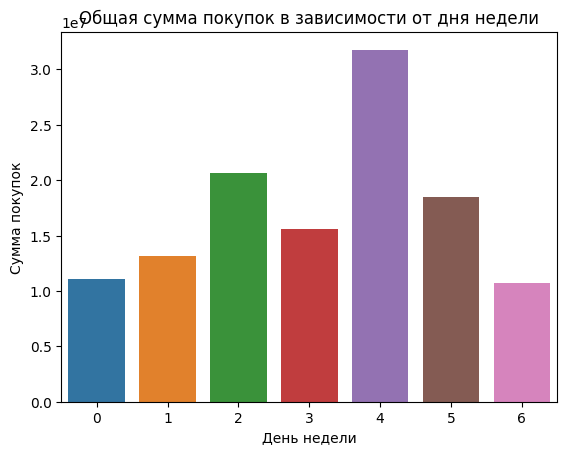

In [96]:
sns.barplot(x='dayofweek', y='total', data=temp1, estimator=np.sum, ci=None)
plt.title('Общая сумма покупок в зависимости от дня недели');
plt.ylabel('Сумма покупок');
plt.xlabel('День недели');

**Общая сумма покупок по всем клиентам наиболее высокая в пятницу.**

**Посмотрим, какие категории товаров более покупаемы.**

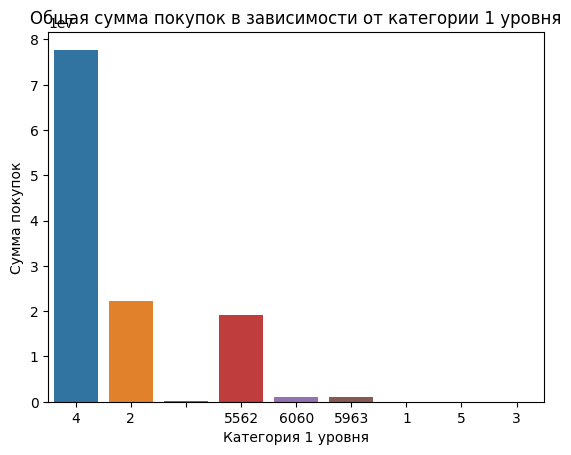

In [97]:
sns.barplot(x='category_ids_1', y='total', data=temp1, estimator=np.sum, ci=None)
plt.title('Общая сумма покупок в зависимости от категории 1 уровня');
plt.ylabel('Сумма покупок');
plt.xlabel('Категория 1 уровня');

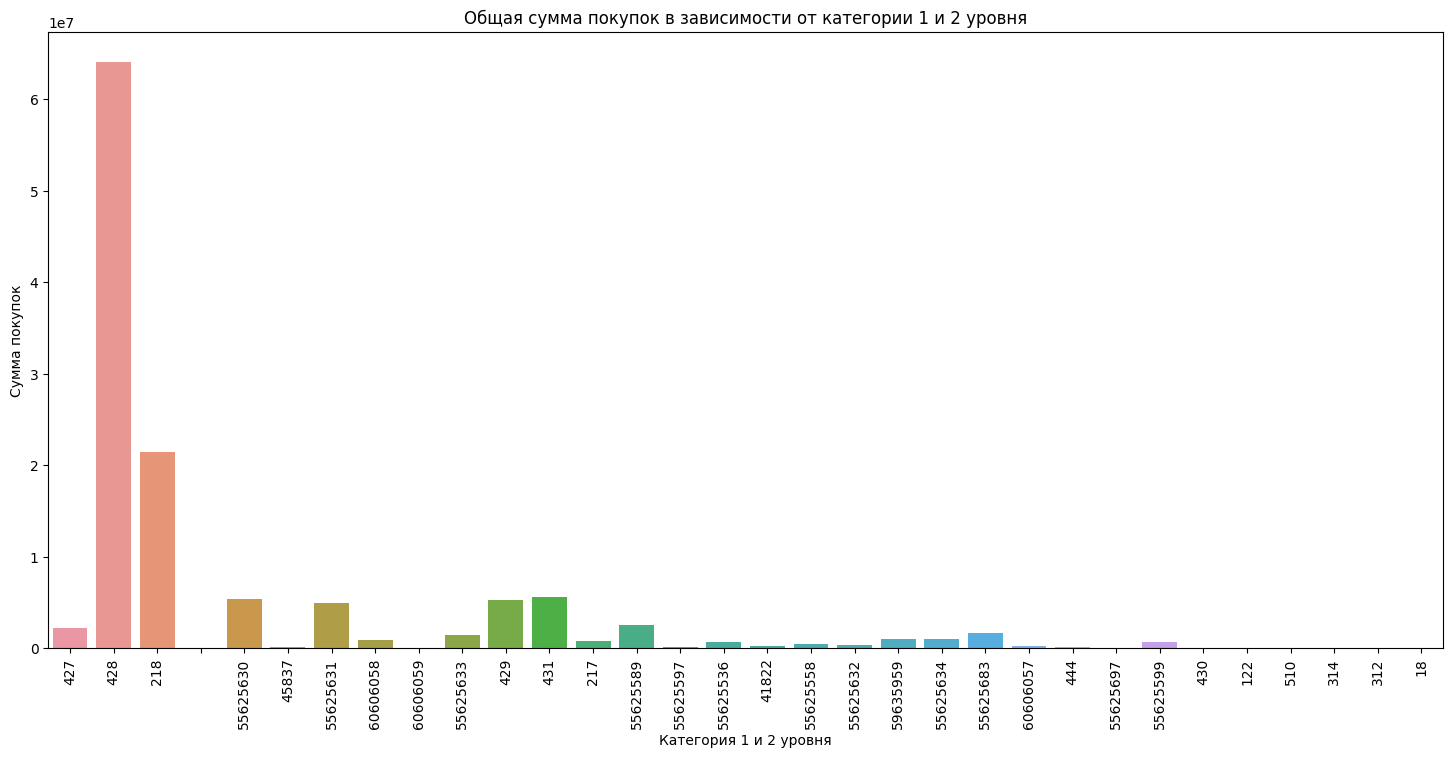

In [98]:
plt.figure(figsize=(18,8))
sns.barplot(x='category_ids_1_2', y='total', data=temp1, estimator=np.sum, ci=None)
plt.title('Общая сумма покупок в зависимости от категории 1 и 2 уровня');
plt.ylabel('Сумма покупок');
plt.xlabel('Категория 1 и 2 уровня');
plt.xticks(rotation=90);

In [99]:
temp2 = messages.set_index('client_id').join(target.set_index('client_id'))
display(temp2.head(3))
temp2.shape

,bulk_campaign_id,message_id,event,channel,date,created_at,target
client_id,,,,,,,
1515915625468060902,4463,1515915625468060902-4463-6285e404c62b9,send,email,2022-05-19,2022-05-19 06:32:28,0.0
1515915625468060902,4568,1515915625468060902-4568-628ddb1f311b5,send,email,2022-05-25,2022-05-25 07:43:38,0.0
1515915625468060902,4591,1515915625468060902-4591-628f1e7ee9206,send,email,2022-05-26,2022-05-26 06:31:29,0.0


(12691188, 7)

**Посмотрим на каналы рассылки в разрезе класса клиентов.**

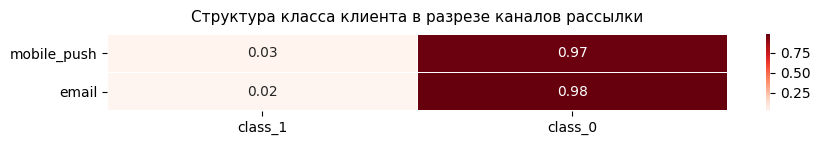

In [100]:
df_temp = pd.DataFrame(temp2.groupby('channel')['target'].agg('mean')).rename(columns={'target':'class_1'})
df_temp['class_0'] = 1 - df_temp['class_1'] 
df_temp = df_temp.sort_values(by='class_1', ascending=False)
plt.figure(dpi=100, figsize=(10,1))
# Заголовок
plt.title('Структура класса клиента в разрезе каналов рассылки', y=1.05, fontsize=11);
sns.heatmap(data=df_temp, linewidth=0.5, cmap='Reds', annot=True, fmt='.2f').set(xlabel='', ylabel='');
plt.yticks(rotation=0);
# "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')

**В разрезе каналов рассылки через mobile_push чуть выше доля класса 1 по сравнению с email.**

**Посмотрим на типы событий в разрезе класса клиентов.**

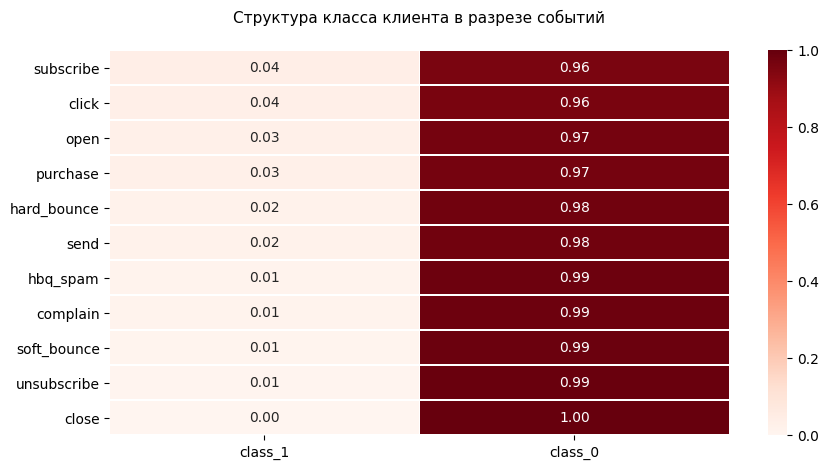

In [101]:
df_temp = pd.DataFrame(temp2.groupby('event')['target'].agg('mean')).rename(columns={'target':'class_1'})
df_temp['class_0'] = 1 - df_temp['class_1'] 
df_temp = df_temp.sort_values(by='class_1', ascending=False)
plt.figure(dpi=100, figsize=(10,5))
# Заголовок
plt.title('Структура класса клиента в разрезе событий', y=1.05, fontsize=11);
sns.heatmap(data=df_temp, linewidth=0.5, cmap='Reds', annot=True, fmt='.2f').set(xlabel='', ylabel='');
plt.yticks(rotation=0);
# "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')

**Клиенты класса 1 имеют чуть выше долю событий: subscribe, click, open, purchase.**

In [102]:
df_temp = messages.groupby('event')['client_id'].agg('nunique')
df_temp = df_temp.sort_values() 
df_temp

event
close              1
subscribe         75
complain         281
hbq_spam         806
soft_bounce     1882
unsubscribe     2209
hard_bounce    12752
purchase       42055
open           44710
click          48060
send           53303
Name: client_id, dtype: int64

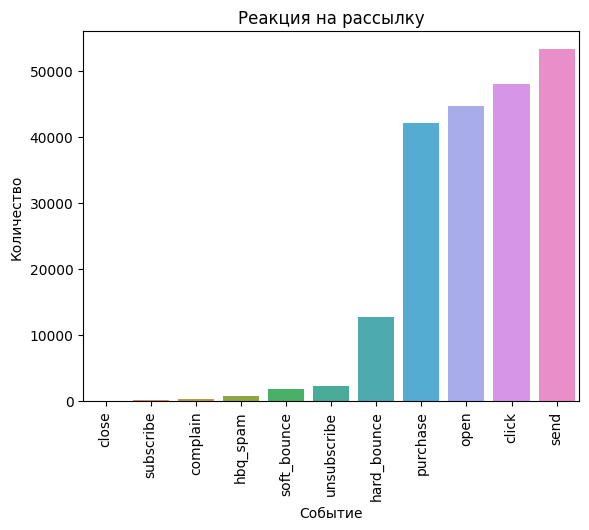

In [103]:
sns.barplot(x=df_temp.index, y=df_temp)
plt.xticks(rotation=90);
plt.title('Реакция на рассылку');
plt.xlabel('Событие')
plt.ylabel('Количество');

## Объединение датафреймов

In [104]:
target.head(3)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


In [105]:
purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,client_id_double,campaign_id_double,message_id_3,match_client_id,category_ids_1,category_ids_2,category_ids_3,category_ids_4,category_ids_5,category_ids_1_2,category_ids_1_2_3,category_ids_1_2_3_4,category_ids_1_2_3_4_5,total,year,month,dayofweek
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,176,458,,427,427176,427176458,427176458,199.0,2022,5,4
3697,1515915625468060902,1,1299.0,"['4', '27', '1828', '1599']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,27,1828,1599,,427,4271828,42718281599,42718281599,1299.0,2022,5,4
3701,1515915625468060902,1,999.0,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1515915625468060902,4617,6290657dac196,1,4,28,244,432,,428,428244,428244432,428244432,999.0,2022,5,4


In [106]:
messages.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


**Чтобы объединить датафреймы по client_id, подготовим сгруппированную информацию на основе датафреймов purchases и messages.**

### Группировка по уникальным клиентам

#### В датафрейме purchases

**Извлекаем из датафрейма с покупками первую, последнюю дату покупки для каждого клиента, также промежуток между первой и последней датой покупок, промежуток между выгрузкой и последней датой покупки.**

In [107]:
data1 = purchases.groupby('client_id').agg(first_date=('date',min), 
                                           last_date=('date',max),
                                           count_buy=("price", 'count'),
                                           total_all=("total", 'sum'),
                                           category_ids_1_nunique=('category_ids_1','nunique'))
                                           
data1['delta_date_last_first'] = (data1['last_date'] - data1['first_date']).dt.days
data1['delta_date_end_last'] = (data1['last_date'].max() - data1['last_date']).dt.days
data1['avg_check'] = data1['total_all']/data1['count_buy'] #средний чек по покупателю, сумма покупок/кол-во покупок
display(data1.head(3))
data1.shape

,first_date,last_date,count_buy,total_all,category_ids_1_nunique,delta_date_last_first,delta_date_end_last,avg_check
client_id,,,,,,,,
1515915625468060902,2022-05-27,2022-05-27,5,4795.0,1,0,630,959.0
1515915625468061003,2023-01-04,2023-01-04,1,1749.0,1,0,408,1749.0
1515915625468061099,2022-05-17,2022-05-17,1,299.0,1,0,640,299.0


(49849, 8)

**Вычислим активность клиентов суммарно по годам в виде количества и суммы**

In [108]:
data2 = purchases.pivot_table(index='client_id', columns='year', aggfunc=['count', 'sum'], values='total', fill_value=0)
data2.columns = ['_'.join(str(x[i]) for i in range(2)) for x in data2.columns.tolist()]
#data2['avg_check_2022'] = data2['sum_2022'] / data2['count_2022']
#data2['avg_check_2023'] = data2['sum_2023'] / data2['count_2023']
#data2['avg_check_2024'] = data2['sum_2024'] / data2['count_2024']
data2 = data2.fillna(0)
display(data2.head(3))
data2.shape

,count_2022,count_2023,count_2024,sum_2022,sum_2023,sum_2024
client_id,,,,,,
1515915625468060902,5,0,0,4795,0,0
1515915625468061003,0,1,0,0,1749,0
1515915625468061099,1,0,0,299,0,0


(49849, 6)

**Вычислим активность клиентов в разрезе год-месяц в виде количества и суммы**

In [109]:
data3 = purchases.pivot_table(index='client_id', columns=['year', 'month'], \
                             aggfunc='count', values='price', fill_value=0)
data3.columns = ['_'.join(str(x[i]) for i in range(2))+'_count_buy' for x in data3.columns.tolist()]
display(data3.head(3))
data3.shape

,2022_5_count_buy,2022_6_count_buy,2022_7_count_buy,2022_8_count_buy,2022_9_count_buy,2022_10_count_buy,2022_11_count_buy,2022_12_count_buy,2023_1_count_buy,2023_2_count_buy,2023_3_count_buy,2023_4_count_buy,2023_5_count_buy,2023_6_count_buy,2023_7_count_buy,2023_8_count_buy,2023_9_count_buy,2023_10_count_buy,2023_11_count_buy,2023_12_count_buy,2024_1_count_buy,2024_2_count_buy
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061003,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061099,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(49849, 22)

In [110]:
data4 = purchases.pivot_table(index='client_id', columns=['year', 'month'], \
                             aggfunc='sum', values='total', fill_value=0)
data4.columns = ['_'.join(str(x[i]) for i in range(2))+'_total_buy' for x in data4.columns.tolist()]
display(data4.head(3))
data4.shape

,2022_5_total_buy,2022_6_total_buy,2022_7_total_buy,2022_8_total_buy,2022_9_total_buy,2022_10_total_buy,2022_11_total_buy,2022_12_total_buy,2023_1_total_buy,2023_2_total_buy,2023_3_total_buy,2023_4_total_buy,2023_5_total_buy,2023_6_total_buy,2023_7_total_buy,2023_8_total_buy,2023_9_total_buy,2023_10_total_buy,2023_11_total_buy,2023_12_total_buy,2024_1_total_buy,2024_2_total_buy
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,4795,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061003,0,0,0,0,0,0,0,0,1749,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061099,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(49849, 22)

**Вычислим активность клиентов по категориям товаров 1 уровня в разрезе количества и суммы.**

In [111]:
data5 = purchases.pivot_table(index='client_id', columns='category_ids_1', aggfunc=['count', 'sum'], values='total', fill_value=0)
data5.columns = ['_'.join(str(x[i]) for i in range(2))+'_cat' for x in data5.columns.tolist()]
data5 = data5.drop(columns={'count__cat', 'sum__cat'}) #удаляем линейно-зависимые столбцы
display(data5.head(3))
data5.shape

,count_1_cat,count_2_cat,count_3_cat,count_4_cat,count_5_cat,count_5562_cat,count_5963_cat,count_6060_cat,sum_1_cat,sum_2_cat,sum_3_cat,sum_4_cat,sum_5_cat,sum_5562_cat,sum_5963_cat,sum_6060_cat
client_id,,,,,,,,,,,,,,,,
1515915625468060902,0,0,0,5,0,0,0,0,0,0,0,4795,0,0,0,0
1515915625468061003,0,0,0,1,0,0,0,0,0,0,0,1749,0,0,0,0
1515915625468061099,0,0,0,1,0,0,0,0,0,0,0,299,0,0,0,0


(49849, 16)

**Вычислим активность клиентов по категориям товаров 1 и 2 уровня в разрезе количества и суммы.**

In [112]:
print('Уникальных комбинаций 1 и 2 уровня:', purchases['category_ids_1_2'].nunique())

Уникальных комбинаций 1 и 2 уровня: 32


In [113]:
data6 = purchases.pivot_table(index='client_id', columns='category_ids_1_2', aggfunc=['count', 'sum'], values='total', fill_value=0)
data6.columns = ['_'.join(str(x[i]) for i in range(2))+'_cat' for x in data6.columns.tolist()]
data6 = data6.drop(columns={'count__cat', 'sum__cat'}) #удаляем линейно-зависимые столбцы
display(data6.head(3))
data6.shape

,count_122_cat,count_18_cat,count_217_cat,count_218_cat,count_312_cat,count_314_cat,count_41822_cat,count_427_cat,count_428_cat,count_429_cat,count_430_cat,count_431_cat,count_444_cat,count_45837_cat,count_510_cat,count_55625536_cat,count_55625558_cat,count_55625589_cat,count_55625597_cat,count_55625599_cat,count_55625630_cat,count_55625631_cat,count_55625632_cat,count_55625633_cat,count_55625634_cat,count_55625683_cat,count_55625697_cat,count_59635959_cat,count_60606057_cat,count_60606058_cat,count_60606059_cat,sum_122_cat,sum_18_cat,sum_217_cat,sum_218_cat,sum_312_cat,sum_314_cat,sum_41822_cat,sum_427_cat,sum_428_cat,sum_429_cat,sum_430_cat,sum_431_cat,sum_444_cat,sum_45837_cat,sum_510_cat,sum_55625536_cat,sum_55625558_cat,sum_55625589_cat,sum_55625597_cat,sum_55625599_cat,sum_55625630_cat,sum_55625631_cat,sum_55625632_cat,sum_55625633_cat,sum_55625634_cat,sum_55625683_cat,sum_55625697_cat,sum_59635959_cat,sum_60606057_cat,sum_60606058_cat,sum_60606059_cat
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1498,3297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061003,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061099,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(49849, 62)

**В модели можно попробовать любой из вариантов: либо колонки с категориями для 1 уровня, либо колонки с категориями для 1 и 2 уровня.**

In [114]:
np.array([4, 5, 6],  dtype='int64')[0]

4

In [115]:
# здесь используем наиболее частое значение для клиента, а не по всей выборке,
# поэтому нет утечки данных. Утечка была бы, если бы мы использовали наиболее частое значение в разрезе всей выборки
func_mode = lambda x: x.mode()[0] if len(x) > 2 else list(x)[0]  # Можно использовать свои собственные функции
data7 = purchases.groupby("client_id").agg(campaign_id_top=("campaign_id_double", func_mode),
                                           message_id_3_top=("message_id_3", func_mode),
                                           dayofweek_top=("dayofweek", func_mode)
                                                                                    )
data7['campaign_id_top'] = data7['campaign_id_top'].astype('int32')
display(data7.head(3))
data7.shape

,campaign_id_top,message_id_3_top,dayofweek_top
client_id,,,
1515915625468060902,4617,6290657dac196,4
1515915625468061003,9148,63b54b04855a4,2
1515915625468061099,4439,62834141aa538,1


(49849, 3)

In [116]:
# здесь используем наиболее частое значение для клиента, а не по всей выборке,
# поэтому нет утечки данных. Утечка была бы, если бы мы использовали наиболее частое значение в разрезе всей выборки
func_mode = lambda x: x.mode()[0] if len(x) > 2 else list(x)[0]  # Можно использовать свои собственные функции
data8 = purchases.groupby("client_id").agg(category_ids_1_top=("category_ids_1", func_mode),
                                           category_ids_1_2_top=("category_ids_1_2", func_mode)
                                                                                  )
data8['category_ids_1_top'] = data8['category_ids_1_top'].apply(lambda x: x if len(x) > 0 else '0')
data8['category_ids_1_2_top'] = data8['category_ids_1_2_top'].apply(lambda x: x if len(x) > 0 else '0')
data8['category_ids_1_top'] = data8['category_ids_1_top'].astype('int32')
data8['category_ids_1_2_top'] = data8['category_ids_1_2_top'].astype('int32')
display(data8.head(3))
data8.shape

,category_ids_1_top,category_ids_1_2_top
client_id,,
1515915625468060902,4,428
1515915625468061003,4,428
1515915625468061099,4,428


(49849, 2)

In [117]:
# здесь используем наиболее частое значение для клиента, а не по всей выборке,
# поэтому нет утечки данных. Утечка была бы, если бы мы использовали наиболее частое значение в разрезе всей выборки
func_mode = lambda x: x.mode()[0] if len(x) > 2 else list(x)[0]  # Можно использовать свои собственные функции
data9 = purchases.groupby("client_id").agg(message_id=("message_id", func_mode)
                                          )

display(data9.head(3))
data9.shape

,message_id
client_id,
1515915625468060902,1515915625468060902-4617-6290657dac196
1515915625468061003,1515915625468061003-9148-63b54b04855a4
1515915625468061099,1515915625468061099-4439-62834141aa538


(49849, 1)

**Создадим датафрейм purchases_groupby на основе промежуточных датафреймов data1,...,data 8.**

In [118]:
purchases_groupby = data1.join([data2, data3, data4, data5, data6, data7, data8, data9])
display(purchases_groupby.head(3))
purchases_groupby.shape

,first_date,last_date,count_buy,total_all,category_ids_1_nunique,delta_date_last_first,delta_date_end_last,avg_check,count_2022,count_2023,count_2024,sum_2022,sum_2023,sum_2024,2022_5_count_buy,2022_6_count_buy,2022_7_count_buy,2022_8_count_buy,2022_9_count_buy,2022_10_count_buy,2022_11_count_buy,2022_12_count_buy,2023_1_count_buy,2023_2_count_buy,2023_3_count_buy,2023_4_count_buy,2023_5_count_buy,2023_6_count_buy,2023_7_count_buy,2023_8_count_buy,2023_9_count_buy,2023_10_count_buy,2023_11_count_buy,2023_12_count_buy,2024_1_count_buy,2024_2_count_buy,2022_5_total_buy,2022_6_total_buy,2022_7_total_buy,2022_8_total_buy,2022_9_total_buy,2022_10_total_buy,2022_11_total_buy,2022_12_total_buy,2023_1_total_buy,2023_2_total_buy,2023_3_total_buy,2023_4_total_buy,2023_5_total_buy,2023_6_total_buy,2023_7_total_buy,2023_8_total_buy,2023_9_total_buy,2023_10_total_buy,2023_11_total_buy,2023_12_total_buy,2024_1_total_buy,2024_2_total_buy,count_1_cat,count_2_cat,count_3_cat,count_4_cat,count_5_cat,count_5562_cat,count_5963_cat,count_6060_cat,sum_1_cat,sum_2_cat,sum_3_cat,sum_4_cat,sum_5_cat,sum_5562_cat,sum_5963_cat,sum_6060_cat,count_122_cat,count_18_cat,count_217_cat,count_218_cat,count_312_cat,count_314_cat,count_41822_cat,count_427_cat,count_428_cat,count_429_cat,count_430_cat,count_431_cat,count_444_cat,count_45837_cat,count_510_cat,count_55625536_cat,count_55625558_cat,count_55625589_cat,count_55625597_cat,count_55625599_cat,count_55625630_cat,count_55625631_cat,count_55625632_cat,count_55625633_cat,count_55625634_cat,count_55625683_cat,count_55625697_cat,count_59635959_cat,count_60606057_cat,count_60606058_cat,count_60606059_cat,sum_122_cat,sum_18_cat,sum_217_cat,sum_218_cat,sum_312_cat,sum_314_cat,sum_41822_cat,sum_427_cat,sum_428_cat,sum_429_cat,sum_430_cat,sum_431_cat,sum_444_cat,sum_45837_cat,sum_510_cat,sum_55625536_cat,sum_55625558_cat,sum_55625589_cat,sum_55625597_cat,sum_55625599_cat,sum_55625630_cat,sum_55625631_cat,sum_55625632_cat,sum_55625633_cat,sum_55625634_cat,sum_55625683_cat,sum_55625697_cat,sum_59635959_cat,sum_60606057_cat,sum_60606058_cat,sum_60606059_cat,campaign_id_top,message_id_3_top,dayofweek_top,category_ids_1_top,category_ids_1_2_top,message_id
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,2022-05-27,2022-05-27,5,4795.0,1,0,630,959.0,5,0,0,4795,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4795,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,4795,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1498,3297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4617,6290657dac196,4,4,428,1515915625468060902-4617-6290657dac196
1515915625468061003,2023-01-04,2023-01-04,1,1749.0,1,0,408,1749.0,0,1,0,0,1749,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1749,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9148,63b54b04855a4,2,4,428,1515915625468061003-9148-63b54b04855a4
1515915625468061099,2022-05-17,2022-05-17,1,299.0,1,0,640,299.0,1,0,0,299,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,299,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4439,62834141aa538,1,4,428,1515915625468061099-4439-62834141aa538


(49849, 142)

In [119]:
purchases_groupby.select_dtypes(exclude=['object','number']).columns.tolist()

['first_date', 'last_date']

In [120]:
purchases_groupby.select_dtypes(include='object').columns.tolist()

['message_id_3_top', 'message_id']

In [121]:
len(purchases_groupby.select_dtypes(include='number').columns.tolist())

138

**В датафрейме purchases_groupby - 141 колонка с признаками (2 колонки с датами, 1 колонка - строковая, 138 колонок - числовых). Мы не знаем, какие колонки будут полезны. Большое количество колонок может и не привести к улучшенным результатам,а даже снизить точность модели. Поэтому, вероятно, не все колонки будут участвовать при моделировании.**

#### В датафрейме messages

In [122]:
messages.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [123]:
messages.shape

(12691188, 7)

**Извлечем информацию по клиентам в разрезе каналов: email, mobile_push.**

In [124]:
d1 = messages.pivot_table(index='client_id', columns='channel', aggfunc=['count'], values='bulk_campaign_id', fill_value=0)
d1.columns = ['_'.join(str(x[i]) for i in range(2)) for x in d1.columns.tolist()]
display(d1.head(3))
d1.shape

,count_email,count_mobile_push
client_id,,
1515915625468060902,177,0
1515915625468061003,165,0
1515915625468061099,182,94


(53329, 2)

**Либо использовать общую информацию по каналам без агрегации.**

In [125]:
d2 = messages.groupby('client_id').agg(count_channel=("channel", 'count'))
display(d2.head(3))
d2.shape

,count_channel
client_id,
1515915625468060902,177
1515915625468061003,165
1515915625468061099,276


(53329, 1)

**Извлечем информацию по клиентам в разрезе событий.**

In [126]:
d3 = messages.pivot_table(index='client_id', columns='event', aggfunc=['count'], values='bulk_campaign_id', fill_value=0)
d3.columns = ['_'.join(str(x[i]) for i in range(2)) for x in d3.columns.tolist()]
display(d3.head(3))
d3.shape

,count_click,count_close,count_complain,count_hard_bounce,count_hbq_spam,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe
client_id,,,,,,,,,,,
1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
1515915625468061099,8,0,0,2,0,51,0,215,0,0,0


(53329, 11)

**Также создадим столбец с общим количеством событий без агрегации.**

In [127]:
d4 = messages.groupby('client_id').agg(event_count=("event", 'count'))
display(d4.head(3))
d4.shape

,event_count
client_id,
1515915625468060902,177
1515915625468061003,165
1515915625468061099,276


(53329, 1)

**Извлечем информацию из даты.**

In [128]:
d5 = messages.groupby('client_id').agg(first_date_messages=('date', min), 
                                           last_date_messages=('date', max)
                                           )
                                           
d5['delta_date_last_first_messages'] = (d5['last_date_messages'] - d5['first_date_messages']).dt.days
d5['delta_date_end_last_messages'] = (d5['last_date_messages'].max() - d5['first_date_messages']).dt.days
display(d5.head(3))
d5.shape

,first_date_messages,last_date_messages,delta_date_last_first_messages,delta_date_end_last_messages
client_id,,,,
1515915625468060902,2022-05-19,2024-01-19,610,637
1515915625468061003,2022-05-20,2024-02-13,634,636
1515915625468061099,2022-05-19,2024-02-13,635,637


(53329, 4)

**Объединим датафреймы со сгруппированной информацией по клиентам, полученной на основе таблицы messages.**

In [129]:
messages_groupby = d1.join([d2, d3, d4, d5])
display(messages_groupby.head(3)) 
messages_groupby.shape

,count_email,count_mobile_push,count_channel,count_click,count_close,count_complain,count_hard_bounce,count_hbq_spam,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,event_count,first_date_messages,last_date_messages,delta_date_last_first_messages,delta_date_end_last_messages
client_id,,,,,,,,,,,,,,,,,,,
1515915625468060902,177,0,177,10,0,0,0,0,35,5,126,0,0,1,177,2022-05-19,2024-01-19,610,637
1515915625468061003,165,0,165,5,0,0,0,0,5,1,154,0,0,0,165,2022-05-20,2024-02-13,634,636
1515915625468061099,182,94,276,8,0,0,2,0,51,0,215,0,0,0,276,2022-05-19,2024-02-13,635,637


(53329, 19)

In [130]:
messages_groupby.select_dtypes(exclude=['object','number']).columns.tolist()

['first_date_messages', 'last_date_messages']

In [131]:
messages_groupby.select_dtypes(include='object').columns.tolist()

[]

In [132]:
len(messages_groupby.select_dtypes(include='number').columns.tolist())

17

**В датафрейме messages_groupby - 19 колонок с признаками (2 колонки с датами, 17 колонок - числовых).**

#### Объединение сгруппированных датафреймов по уникальным клиентам из target

In [133]:
df_groupby = target.set_index('client_id').join([purchases_groupby, messages_groupby])


In [134]:
df_groupby.head(3)

,target,first_date,last_date,count_buy,total_all,category_ids_1_nunique,delta_date_last_first,delta_date_end_last,avg_check,count_2022,count_2023,count_2024,sum_2022,sum_2023,sum_2024,2022_5_count_buy,2022_6_count_buy,2022_7_count_buy,2022_8_count_buy,2022_9_count_buy,2022_10_count_buy,2022_11_count_buy,2022_12_count_buy,2023_1_count_buy,2023_2_count_buy,2023_3_count_buy,2023_4_count_buy,2023_5_count_buy,2023_6_count_buy,2023_7_count_buy,2023_8_count_buy,2023_9_count_buy,2023_10_count_buy,2023_11_count_buy,2023_12_count_buy,2024_1_count_buy,2024_2_count_buy,2022_5_total_buy,2022_6_total_buy,2022_7_total_buy,2022_8_total_buy,2022_9_total_buy,2022_10_total_buy,2022_11_total_buy,2022_12_total_buy,2023_1_total_buy,2023_2_total_buy,2023_3_total_buy,2023_4_total_buy,2023_5_total_buy,2023_6_total_buy,2023_7_total_buy,2023_8_total_buy,2023_9_total_buy,2023_10_total_buy,2023_11_total_buy,2023_12_total_buy,2024_1_total_buy,2024_2_total_buy,count_1_cat,count_2_cat,count_3_cat,count_4_cat,count_5_cat,count_5562_cat,count_5963_cat,count_6060_cat,sum_1_cat,sum_2_cat,sum_3_cat,sum_4_cat,sum_5_cat,sum_5562_cat,sum_5963_cat,sum_6060_cat,count_122_cat,count_18_cat,count_217_cat,count_218_cat,count_312_cat,count_314_cat,count_41822_cat,count_427_cat,count_428_cat,count_429_cat,count_430_cat,count_431_cat,count_444_cat,count_45837_cat,count_510_cat,count_55625536_cat,count_55625558_cat,count_55625589_cat,count_55625597_cat,count_55625599_cat,count_55625630_cat,count_55625631_cat,count_55625632_cat,count_55625633_cat,count_55625634_cat,count_55625683_cat,count_55625697_cat,count_59635959_cat,count_60606057_cat,count_60606058_cat,count_60606059_cat,sum_122_cat,sum_18_cat,sum_217_cat,sum_218_cat,sum_312_cat,sum_314_cat,sum_41822_cat,sum_427_cat,sum_428_cat,sum_429_cat,sum_430_cat,sum_431_cat,sum_444_cat,sum_45837_cat,sum_510_cat,sum_55625536_cat,sum_55625558_cat,sum_55625589_cat,sum_55625597_cat,sum_55625599_cat,sum_55625630_cat,sum_55625631_cat,sum_55625632_cat,sum_55625633_cat,sum_55625634_cat,sum_55625683_cat,sum_55625697_cat,sum_59635959_cat,sum_60606057_cat,sum_60606058_cat,sum_60606059_cat,campaign_id_top,message_id_3_top,dayofweek_top,category_ids_1_top,category_ids_1_2_top,message_id,count_email,count_mobile_push,count_channel,count_click,count_close,count_complain,count_hard_bounce,count_hbq_spam,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,event_count,first_date_messages,last_date_messages,delta_date_last_first_messages,delta_date_end_last_messages
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0.0,2022-05-27,2022-05-27,5.0,4795.0,1.0,0.0,630.0,959.0,5.0,0.0,0.0,4795.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1498.0,3297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4617.0,6290657dac196,4.0,4.0,428.0,1515915625468060902-4617-6290657dac196,177.0,0.0,177.0,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,177.0,2022-05-19,2024-01-19,610.0,637.0
1515915625468061003,1.0,2023-01-04,2023-01-04,1.0,1749.0,1.0,0.0,408.0,1749.0,0.0,1.0,0.0,0.0,1749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1749.0,0.0,0.0,

In [135]:
#df_groupby['delta_time_purchases_messages_first'] = (df_groupby['first_date'] - df_groupby['first_date_messages']).dt.days
df_groupby['delta_time_purchases_messages_last'] = (df_groupby['last_date'] - df_groupby['last_date_messages']).dt.days
df_groupby['delta_time_purchases_messages_last'] = df_groupby['delta_time_purchases_messages_last'].fillna(0)
# удалим колонки с датами
df_groupby = df_groupby.drop(columns=df_groupby.select_dtypes(exclude=['object', 'number']).columns.tolist())

In [136]:
df_groupby.shape

(49849, 159)

In [137]:
df_groupby.select_dtypes(exclude=['object', 'number']).columns.tolist()

[]

In [138]:
df_groupby.select_dtypes(include=['object']).columns.tolist()

['message_id_3_top', 'message_id']

In [139]:
len(df_groupby.select_dtypes(include=['number']).columns.tolist())

157

**В полученном объединенном датафрейме 49849 строк, 158 столбцов (157 - числовых, 1 - категориальный).**

**Заполним образовавшиеся при объединении пропуски в числовых колонках нулями, а в текстовой колонке - 'unknown'.**

In [140]:
df_groupby['message_id_3_top'] = df_groupby['message_id_3_top'].fillna('unknown')
df_groupby = df_groupby.fillna(0)
df_groupby.isna().sum().sum()

0

**Пропуски заполнены.**

**При объединении таблиц произошла конвертация типов данных с int на float в связи с появлением пропусков NAN.**

**Преобразуем типы данных обратно из float в int.**

In [141]:
lst_int32 = purchases_groupby.select_dtypes(include='int32').columns.tolist() + \
  messages_groupby.select_dtypes(include='int32').columns.tolist() 
lst_int64 = purchases_groupby.select_dtypes(include='int64').columns.tolist() + \
   messages_groupby.select_dtypes(include='int64').columns.tolist() 

In [142]:
df_groupby[lst_int32] = df_groupby[lst_int32].astype('int32')
df_groupby[lst_int64] = df_groupby[lst_int64].astype('int64')

**Создадим также искусственный столбец со средневзвешенным сроком и со средневзвешенным дисконтированным сроком. Эти характеристики используют только данные по конкретному объекту, не принимают данные по другим объектам выборки. Поэтому эти столбцы вполне можно создавать, не разделяя данные на выборки (обучающую, тестовую). Если бы в расчетах участвовали статистические показатели, то необходимо было бы сначала разделить данные на выборки и только потом создавать искусственные столбцы, чтобы не было утечки. Если статистические показатели по выборке не участвуют, то утечки не произойдет.**

In [143]:
# здесь берем нужные нам столбцы
data4.columns

Index(['2022_5_total_buy', '2022_6_total_buy', '2022_7_total_buy',
       '2022_8_total_buy', '2022_9_total_buy', '2022_10_total_buy',
       '2022_11_total_buy', '2022_12_total_buy', '2023_1_total_buy',
       '2023_2_total_buy', '2023_3_total_buy', '2023_4_total_buy',
       '2023_5_total_buy', '2023_6_total_buy', '2023_7_total_buy',
       '2023_8_total_buy', '2023_9_total_buy', '2023_10_total_buy',
       '2023_11_total_buy', '2023_12_total_buy', '2024_1_total_buy',
       '2024_2_total_buy'],
      dtype='object')

In [144]:
# создание средневзвешенного срока
lst = ['2022_5_total_buy', '2022_6_total_buy', '2022_7_total_buy',
       '2022_8_total_buy', '2022_9_total_buy', '2022_10_total_buy',
       '2022_11_total_buy', '2022_12_total_buy', '2023_1_total_buy',
       '2023_2_total_buy', '2023_3_total_buy', '2023_4_total_buy',
       '2023_5_total_buy', '2023_6_total_buy', '2023_7_total_buy',
       '2023_8_total_buy', '2023_9_total_buy', '2023_10_total_buy',
       '2023_11_total_buy', '2023_12_total_buy', '2024_1_total_buy',
       '2024_2_total_buy']

def func_time_avg(row):
    s=0
    sum=0
    for i in range(len(lst)):
        s += row[lst[i]]*(i+1)
        sum += row[lst[i]]
    return s/sum

In [145]:
df_groupby['time_avg'] = df_groupby.apply(func_time_avg, axis=1)
df_groupby['time_avg']

client_id
1515915625468060902     1.000000
1515915625468061003     9.000000
1515915625468061099     1.000000
1515915625468061100    22.000000
1515915625468061170    11.563982
                         ...    
1515915626010261344    22.000000
1515915626010266132    22.000000
1515915626010439406    22.000000
1515915626010443527    22.000000
1515915626010443624    22.000000
Name: time_avg, Length: 49849, dtype: float64

**Аналогично создадим средневзвешенный дисконтированный срок. Будем использовать очень грубое приближение, как будто нам неизвестна точная дата, а только месяц и год.**  Ставка дисконтирования из расчета 1% за месяц. Здесь остается открытым вопрос выбора ставки дисконтирования. В теории, как правило, ее принимают равной некой безрисковой ставке плюс поправка на риск. 

**Этот признак также можно генерить без деления на подвыборки, так как не используется статистика по другим объектам, используется только информация для конктретного объекта. Следовательно утечки не будет.**

In [146]:
# создание средневзвешенного дисконтированного срока
def func_time_avg_disc(row):
    s=0
    sum=0
    disc=1.01**(-1) # ставка дисконтирования
    k = len(lst) - 1
    for i in range(len(lst)):
        s += row[lst[i]] * (i+1) * disc**k
        sum += row[lst[i]]
        k -= 1
    if sum > 0:
        rez = s / sum
    else:
        rez = 0
    return rez

In [147]:
df_groupby['time_avg_disc'] = df_groupby.apply(func_time_avg_disc, axis=1)
df_groupby['time_avg_disc']

client_id
1515915625468060902     0.811430
1515915625468061003     7.907963
1515915625468061099     0.811430
1515915625468061100    22.000000
1515915625468061170    10.436553
                         ...    
1515915626010261344    22.000000
1515915626010266132    22.000000
1515915626010439406    22.000000
1515915626010443527    22.000000
1515915626010443624    22.000000
Name: time_avg_disc, Length: 49849, dtype: float64

## Моделирование

### CatBoost

**У нас две нечисловые ячейки.**

In [148]:
df_groupby.select_dtypes(exclude='number')

,message_id_3_top,message_id
client_id,,
1515915625468060902,6290657dac196,1515915625468060902-4617-6290657dac196
1515915625468061003,63b54b04855a4,1515915625468061003-9148-63b54b04855a4
1515915625468061099,62834141aa538,1515915625468061099-4439-62834141aa538
1515915625468061100,65c5c55eeb9e0,1515915625468061100-14623-65c5c55eeb9e0
1515915625468061170,641ad2cda77a2,1515915625468061170-11144-641ad2cda77a2
...,...,...
1515915626010261344,65cdb6d56c4c8,1515915626010261344-14648-65cdb6d56c4c8
1515915626010266132,65c5c5acbad8c,1515915625999374481-14623-65c5c5acbad8c
1515915626010439406,65cf3abfe4f0d,1515915625776605028-14662-65cf3abfe4f0d


**Посмотрим на корреляцию входных признаков с целевой переменной, какие признаки наиболее важные по корреляции phik.**

In [149]:
df_groupby['message_id_3_top'].nunique(), df_groupby['message_id'].nunique()

(42857, 42808)

**Категориальные признаки "message_id_3_top", "'message_id" в расчете корреляций phik использовать не будем, так как они содержат огромное количество уникальных категорий. Это занимает большие временные ресурсы.**

In [150]:
interval_cols = df_groupby.select_dtypes(include='number').columns.tolist() # непрерывные столбцы
# выведем коэффциенты корреляции phik
sp = df_groupby.select_dtypes(include='number').phik_matrix(interval_cols=interval_cols)['target'].sort_values(ascending=False)

In [151]:
sp[1:20]

delta_date_last_first    0.134146
delta_date_end_last      0.115966
count_428_cat            0.102005
time_avg_disc            0.093683
count_2024               0.087655
count_4_cat              0.085787
time_avg                 0.085025
count_buy                0.078867
2024_2_count_buy         0.071898
count_click              0.070769
count_431_cat            0.070660
count_purchase           0.069807
count_55625634_cat       0.065177
2023_6_count_buy         0.064882
count_427_cat            0.064418
count_mobile_push        0.064416
campaign_id_top          0.063862
2024_1_count_buy         0.061507
count_429_cat            0.060371
Name: target, dtype: float64

**Расположим признаки в порядке убывания. Это можно использовать при отборе признаков.**

In [152]:
print(sp.index.tolist())

['target', 'delta_date_last_first', 'delta_date_end_last', 'count_428_cat', 'time_avg_disc', 'count_2024', 'count_4_cat', 'time_avg', 'count_buy', '2024_2_count_buy', 'count_click', 'count_431_cat', 'count_purchase', 'count_55625634_cat', '2023_6_count_buy', 'count_427_cat', 'count_mobile_push', 'campaign_id_top', '2024_1_count_buy', 'count_429_cat', 'count_2023', 'count_open', 'category_ids_1_nunique', 'count_send', 'delta_time_purchases_messages_last', '2023_12_count_buy', 'count_5562_cat', 'event_count', 'count_channel', '2022_7_count_buy', '2023_10_count_buy', 'count_2022', 'sum_2023', 'sum_428_cat', '2023_10_total_buy', 'count_55625631_cat', 'count_60606057_cat', '2023_11_count_buy', 'total_all', 'sum_4_cat', '2023_5_count_buy', 'sum_55625634_cat', 'count_hard_bounce', '2023_12_total_buy', 'sum_430_cat', 'sum_5562_cat', 'count_55625632_cat', '2022_5_count_buy', 'sum_55625599_cat', '2023_1_total_buy', '2023_4_count_buy', 'sum_55625632_cat', 'count_2_cat', 'count_55625599_cat', 'sum

**Будем использовать 3 выборки: обучающую, валидационную, тестовую.**

**CatBoost прекрасно работает из коробки, чаще даже лучше, чем менять настройки по умолчанию. Практически все настройки используем по умолчанию, за исключением learning_rate, iterations = 1000, l2_leaf_reg.** 

**В ходе эксперимента было обнаружено, что 'message_id_3_top' в случае наличия 'message_id' избыточен, поэтому удалим его.**  

In [153]:
df_groupby = df_groupby.drop(columns={'message_id_3_top'})

В целях оптимизации кода создадим функцию для работы с CatBoost.

In [154]:
def model_rez(df, learning_rate = 0.03, iterations = 1000, l2_leaf_reg=5):
    
    if 'target' in df.columns.tolist():
        X =  df.drop(columns={'target'}).columns.tolist() 
    else:
        X = df.columns.tolist() 
    y =  'target'
    cat_features = ['message_id']
    X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], stratify=df[y], test_size=0.2,random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,\
                                    test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)
    
    
    parameters =  {
        'iterations': iterations,
        'cat_features':cat_features,
        'verbose':100,
        'eval_metric':  'AUC',   
           
        'random_seed': RANDOM_STATE,
        'learning_rate': learning_rate, 
        'l2_leaf_reg': l2_leaf_reg,
    
        'auto_class_weights':'Balanced',
            
            }
    
    model_cbr = CatBoostClassifier(**parameters)
    
    model_cbr.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    print('Отчет по классификации')
    print()
    print(classification_report(y_val,model_cbr.predict(X_val)))
    print('Метрика roc_auc на валидационной выборке', roc_auc_score(y_val, model_cbr.predict_proba(X_val)[:,1]))
    print('Метрика roc_auc на тестовой выборке', roc_auc_score(y_test, model_cbr.predict_proba(X_test)[:,1]))
    return model_cbr, X_val

In [155]:
model_cbr, X_val = model_rez(df=df_groupby, learning_rate = 0.03, iterations = 300)

0:	test: 0.7157655	best: 0.7157655 (0)	total: 196ms	remaining: 58.7s
100:	test: 0.8037524	best: 0.8068319 (57)	total: 4.26s	remaining: 8.39s
200:	test: 0.7968363	best: 0.8068319 (57)	total: 8.33s	remaining: 4.1s
299:	test: 0.7966786	best: 0.8068319 (57)	total: 12.4s	remaining: 0us

bestTest = 0.8068318794
bestIteration = 57

Shrink model to first 58 iterations.
Отчет по классификации

              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      7822
         1.0       0.06      0.68      0.10       154

    accuracy                           0.77      7976
   macro avg       0.52      0.73      0.48      7976
weighted avg       0.97      0.77      0.85      7976

Метрика roc_auc на валидационной выборке 0.8068318794475787
Метрика roc_auc на тестовой выборке 0.7947390400218177


**Посмотрим на важность признаков, используя встроенную функцию CatBoost.**

In [156]:
df_feature_importance = model_cbr.get_feature_importance(prettified=True)
sp = df_feature_importance['Feature Id'].tolist()
df_feature_importance[:30]

,Feature Id,Importances
0,message_id,15.567254
1,delta_date_last_first,9.401249
2,delta_date_end_last,7.850433
3,event_count,6.491264
4,count_click,4.996080
5,count_channel,4.418676
6,time_avg,3.737639
7,count_mobile_push,3.027951
8,sum_2022,2.989860
9,avg_check,2.973023


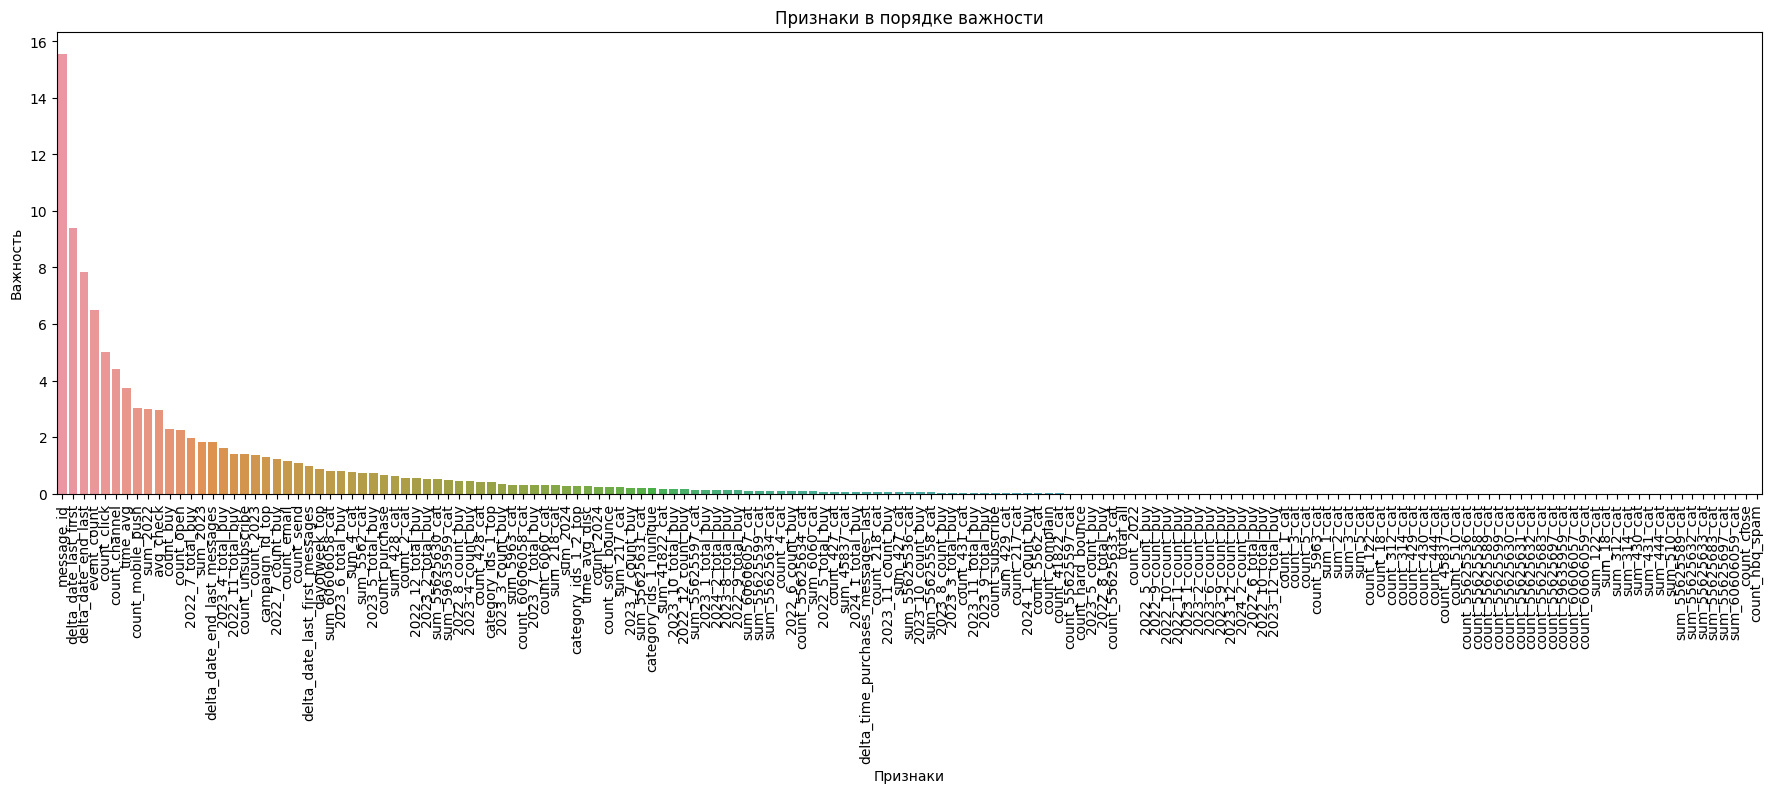

In [157]:
plt.figure(figsize=(22,6))
sns.barplot(data=df_feature_importance, x=df_feature_importance['Feature Id'], y=df_feature_importance['Importances'])
plt.xticks(rotation=90);
plt.title('Признаки в порядке важности');
plt.xlabel('Признаки');
plt.ylabel('Важность');

**Посмотрим на важность признаков, используя SHAP.**

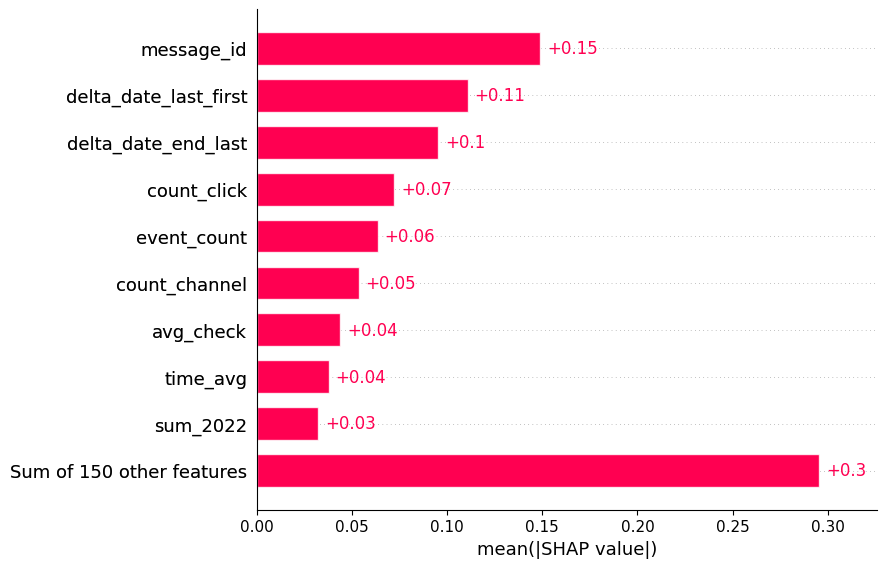

In [158]:
import shap
shap.initjs() # для красивой визуализации shap
# инициализация объекта
#explainer = shap.TreeExplainer(model_cbr, X_val, feature_perturbation="tree_path_dependent")
explainer = shap.TreeExplainer(model_cbr,feature_perturbation="tree_path_dependent")
# вычисление значений Шепли для тестовой выборки
shap_values_test = explainer(X_val)
shap.plots.bar(shap_values_test)

**Видим, что наиболее важные признаки для модели - идентификатор сообщения, временные признаки, признаки с количеством событий, количеством каналов, произведение средневзвешенного чека и продолжительности  между последней и первой датами покупок. Значит будем создавать далее для улучшения модели признаки в этом направлении.**

**Попробуем значительно уменьшить количество входных признаков, используя результаты shap-визуализации  и важность признаков по встроенной функции CatBoost. Будем использовать 30 признаков.**

In [159]:
model_cbr, X_val = model_rez(df=df_groupby[['target']+ sp[:30]], learning_rate = 0.03, iterations = 300)

0:	test: 0.7395740	best: 0.7395740 (0)	total: 42.9ms	remaining: 12.8s
100:	test: 0.8042090	best: 0.8060187 (74)	total: 3.56s	remaining: 7.03s
200:	test: 0.7996813	best: 0.8060187 (74)	total: 7.03s	remaining: 3.46s
299:	test: 0.7968953	best: 0.8060187 (74)	total: 10.5s	remaining: 0us

bestTest = 0.8060187384
bestIteration = 74

Shrink model to first 75 iterations.
Отчет по классификации

              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      7822
         1.0       0.06      0.69      0.10       154

    accuracy                           0.76      7976
   macro avg       0.52      0.73      0.48      7976
weighted avg       0.97      0.76      0.85      7976

Метрика roc_auc на валидационной выборке 0.806018738357015
Метрика roc_auc на тестовой выборке 0.8016577393127429


### Создание еще дополнительных признаков

In [160]:
def func_new_column(data):
    data['count_open_click'] = data['count_open']/data['count_click']
    data['count_open_click'] = data['count_open_click'].fillna(0)
    data['count_open_purchase'] = data['count_open']/data['count_purchase']
    data['count_open_purchase'] = data['count_open_purchase'].fillna(0)
    data['count_open_event_count'] = data['count_open']/data['event_count']
    data['count_open_event_count'] = data['count_open_event_count'].fillna(0)
    data['count_click_event_count'] = data['count_click']/data['event_count']
    data['count_click_event_count'] = data['count_click_event_count'].fillna(0)
    data['avg_check_duration'] = data['avg_check'] * data['delta_date_end_last']
    
    return data

In [161]:
df_groupby = func_new_column(df_groupby)

In [162]:
df_groupby['count_main_events'] = df_groupby['count_open']+df_groupby['count_click']+df_groupby['count_purchase']

**Извлечем еще дополнительную информацию из датафрейма messages.**

In [163]:
mes = messages[['event','date', 'channel','client_id']]
mes['year'] = mes.date.dt.year
mes['month'] = mes.date.dt.month
mes = mes.query('event=="open" or event=="click" or event=="purchase"')
mes

,event,date,channel,client_id,year,month
0,open,2022-05-19,email,1515915625626736623,2022,5
1,open,2022-05-19,email,1515915625490086521,2022,5
2,open,2022-05-19,email,1515915625553578558,2022,5
3,click,2022-05-19,email,1515915625553578558,2022,5
4,open,2022-05-19,email,1515915625471518311,2022,5
...,...,...,...,...,...,...
12739793,open,2024-02-15,email,1515915625477497874,2024,2
12739794,open,2024-02-15,email,1515915625765994334,2024,2
12739795,open,2024-02-15,email,1515915625545014677,2024,2
12739796,open,2024-02-15,email,1515915625477497874,2024,2


**Создадим отдельные признаки для событий и каналов, используя дамми-переменные.**

In [164]:
mes_new = pd.get_dummies(mes['event']).join([pd.get_dummies(mes['channel']), mes[['client_id', 'year', 'month']]])
mes_new['main_events'] = mes_new['click'] + mes_new['open'] + mes_new['purchase'] 
mes_new['main_channels'] = mes_new['email'] + mes_new['mobile_push']
mes_new

,click,open,purchase,email,mobile_push,client_id,year,month,main_events,main_channels
0,0,1,0,1,0,1515915625626736623,2022,5,1,1
1,0,1,0,1,0,1515915625490086521,2022,5,1,1
2,0,1,0,1,0,1515915625553578558,2022,5,1,1
3,1,0,0,1,0,1515915625553578558,2022,5,1,1
4,0,1,0,1,0,1515915625471518311,2022,5,1,1
...,...,...,...,...,...,...,...,...,...,...
12739793,0,1,0,1,0,1515915625477497874,2024,2,1,1
12739794,0,1,0,1,0,1515915625765994334,2024,2,1,1
12739795,0,1,0,1,0,1515915625545014677,2024,2,1,1
12739796,0,1,0,1,0,1515915625477497874,2024,2,1,1


**Извлечем дополнительную информацию по количеству кликов за каждый месяц.**

**Создадим функцию, так как будем создавать аналогичные столбцы для разных признаков.**

In [165]:
def func_year_month(values):
    f = mes_new.pivot_table(values, index='client_id', columns=['year', 'month'], \
                             aggfunc='sum', fill_value=0)

    f.columns = ['_'.join(str(x[i]) for i in range(2)) + '_count_'+ values for x in f.columns.tolist()]
    display(f.head(3))    
    display(f.shape)
    return f

In [166]:
f1 = func_year_month(values='click')

,2022_5_count_click,2022_6_count_click,2022_7_count_click,2022_8_count_click,2022_9_count_click,2022_10_count_click,2022_11_count_click,2022_12_count_click,2023_1_count_click,2023_2_count_click,2023_3_count_click,2023_4_count_click,2023_5_count_click,2023_6_count_click,2023_7_count_click,2023_8_count_click,2023_9_count_click,2023_10_count_click,2023_11_count_click,2023_12_count_click,2024_1_count_click,2024_2_count_click
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,4,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
1515915625468061003,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,1,0,0,0
1515915625468061099,0,0,0,1,1,0,2,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0


(52079, 22)

**Извлечем дополнительную информацию по количеству событий open за каждый месяц.**

In [167]:
f2 = func_year_month(values='open')

,2022_5_count_open,2022_6_count_open,2022_7_count_open,2022_8_count_open,2022_9_count_open,2022_10_count_open,2022_11_count_open,2022_12_count_open,2023_1_count_open,2023_2_count_open,2023_3_count_open,2023_4_count_open,2023_5_count_open,2023_6_count_open,2023_7_count_open,2023_8_count_open,2023_9_count_open,2023_10_count_open,2023_11_count_open,2023_12_count_open,2024_1_count_open,2024_2_count_open
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,2,4,2,1,4,1,3,0,2,0,1,1,0,0,1,1,0,6,0,2,4,0
1515915625468061003,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0
1515915625468061099,0,2,0,7,2,1,17,15,1,2,0,0,0,2,0,1,0,0,0,0,1,0


(52079, 22)

**Извлечем дополнительную информацию по количеству событий purchase за каждый месяц.**

In [168]:
f3 = func_year_month(values='purchase')

,2022_5_count_purchase,2022_6_count_purchase,2022_7_count_purchase,2022_8_count_purchase,2022_9_count_purchase,2022_10_count_purchase,2022_11_count_purchase,2022_12_count_purchase,2023_1_count_purchase,2023_2_count_purchase,2023_3_count_purchase,2023_4_count_purchase,2023_5_count_purchase,2023_6_count_purchase,2023_7_count_purchase,2023_8_count_purchase,2023_9_count_purchase,2023_10_count_purchase,2023_11_count_purchase,2023_12_count_purchase,2024_1_count_purchase,2024_2_count_purchase
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061003,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(52079, 22)

**Извлечем дополнительную информацию по количеству событий purchase, open, click вместе за каждый месяц.**

In [169]:
f4 = func_year_month(values='main_events')

,2022_5_count_main_events,2022_6_count_main_events,2022_7_count_main_events,2022_8_count_main_events,2022_9_count_main_events,2022_10_count_main_events,2022_11_count_main_events,2022_12_count_main_events,2023_1_count_main_events,2023_2_count_main_events,2023_3_count_main_events,2023_4_count_main_events,2023_5_count_main_events,2023_6_count_main_events,2023_7_count_main_events,2023_8_count_main_events,2023_9_count_main_events,2023_10_count_main_events,2023_11_count_main_events,2023_12_count_main_events,2024_1_count_main_events,2024_2_count_main_events
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,11,4,2,1,6,2,4,0,2,0,1,1,0,0,1,1,0,6,0,2,6,0
1515915625468061003,0,0,0,0,0,1,0,0,3,0,2,0,3,0,0,0,0,0,2,0,0,0
1515915625468061099,0,2,0,8,3,1,19,16,1,3,0,0,0,3,0,2,0,0,0,0,1,0


(52079, 22)

**Извлечем дополнительную информацию по количеству событий purchase, open, click вместе за каждый год.**

**Создадим похожую функцию, отличающуюся только тем, что данные извлекаются только в разрезе года.**

In [170]:
def func_year(values):
    f = mes_new.pivot_table(values, index='client_id', columns=['year'], \
                             aggfunc='sum', fill_value=0)

    f.columns = [str(x) +  '_count_'+ values for x in f.columns.tolist()]
    display(f.head(3))    
    display(f.shape)
    return f

In [171]:
f5 = func_year(values='main_events')

,2022_count_main_events,2023_count_main_events,2024_count_main_events
client_id,,,
1515915625468060902,30,14,6
1515915625468061003,1,10,0
1515915625468061099,49,9,1


(52079, 3)

**Извлечем дополнительную информацию по количеству событий click за каждый год.**

In [172]:
f6 = func_year(values='click')

,2022_count_click,2023_count_click,2024_count_click
client_id,,,
1515915625468060902,8,0,2
1515915625468061003,0,5,0
1515915625468061099,5,3,0


(52079, 3)

**Извлечем дополнительную информацию по количеству событий open за каждый год.**

In [173]:
f7 = func_year(values='open')

,2022_count_open,2023_count_open,2024_count_open
client_id,,,
1515915625468060902,17,14,4
1515915625468061003,1,4,0
1515915625468061099,44,6,1


(52079, 3)

**Извлечем дополнительную информацию по количеству событий purchase за каждый год.**

In [174]:
f8 = func_year(values='purchase')

,2022_count_purchase,2023_count_purchase,2024_count_purchase
client_id,,,
1515915625468060902,5,0,0
1515915625468061003,0,1,0
1515915625468061099,0,0,0


(52079, 3)

**Извлечем дополнительную информацию по количеству каналов за каждый месяц.**

In [175]:
f9 = func_year_month(values='main_channels')

,2022_5_count_main_channels,2022_6_count_main_channels,2022_7_count_main_channels,2022_8_count_main_channels,2022_9_count_main_channels,2022_10_count_main_channels,2022_11_count_main_channels,2022_12_count_main_channels,2023_1_count_main_channels,2023_2_count_main_channels,2023_3_count_main_channels,2023_4_count_main_channels,2023_5_count_main_channels,2023_6_count_main_channels,2023_7_count_main_channels,2023_8_count_main_channels,2023_9_count_main_channels,2023_10_count_main_channels,2023_11_count_main_channels,2023_12_count_main_channels,2024_1_count_main_channels,2024_2_count_main_channels
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,11,4,2,1,6,2,4,0,2,0,1,1,0,0,1,1,0,6,0,2,6,0
1515915625468061003,0,0,0,0,0,1,0,0,3,0,2,0,3,0,0,0,0,0,2,0,0,0
1515915625468061099,0,2,0,8,3,1,19,16,1,3,0,0,0,3,0,2,0,0,0,0,1,0


(52079, 22)

**Извлечем дополнительную информацию по количеству канала mobile_push за каждый месяц.**

In [176]:
f10 = func_year_month(values='mobile_push')

,2022_5_count_mobile_push,2022_6_count_mobile_push,2022_7_count_mobile_push,2022_8_count_mobile_push,2022_9_count_mobile_push,2022_10_count_mobile_push,2022_11_count_mobile_push,2022_12_count_mobile_push,2023_1_count_mobile_push,2023_2_count_mobile_push,2023_3_count_mobile_push,2023_4_count_mobile_push,2023_5_count_mobile_push,2023_6_count_mobile_push,2023_7_count_mobile_push,2023_8_count_mobile_push,2023_9_count_mobile_push,2023_10_count_mobile_push,2023_11_count_mobile_push,2023_12_count_mobile_push,2024_1_count_mobile_push,2024_2_count_mobile_push
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1515915625468061099,0,0,0,6,0,0,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(52079, 22)

**Извлечем дополнительную информацию по количеству канала email за каждый месяц.**

In [177]:
f11 = func_year_month(values='email')

,2022_5_count_email,2022_6_count_email,2022_7_count_email,2022_8_count_email,2022_9_count_email,2022_10_count_email,2022_11_count_email,2022_12_count_email,2023_1_count_email,2023_2_count_email,2023_3_count_email,2023_4_count_email,2023_5_count_email,2023_6_count_email,2023_7_count_email,2023_8_count_email,2023_9_count_email,2023_10_count_email,2023_11_count_email,2023_12_count_email,2024_1_count_email,2024_2_count_email
client_id,,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,11,4,2,1,6,2,4,0,2,0,1,1,0,0,1,1,0,6,0,2,6,0
1515915625468061003,0,0,0,0,0,1,0,0,3,0,2,0,3,0,0,0,0,0,2,0,0,0
1515915625468061099,0,2,0,2,3,1,5,2,1,3,0,0,0,3,0,2,0,0,0,0,1,0


(52079, 22)

**Объединим новые созданные данные в единый датафрейм f_n. Затем объединим его с датафреймом df_groupby.**

In [178]:
f_n=f4.join([f1,f2,f3,f5,f6,f7,f8,f9,f10,f11])

In [179]:
df_new = df_groupby.join([f_n]).fillna(0)
df_new

,target,count_buy,total_all,category_ids_1_nunique,delta_date_last_first,delta_date_end_last,avg_check,count_2022,count_2023,count_2024,sum_2022,sum_2023,sum_2024,2022_5_count_buy,2022_6_count_buy,2022_7_count_buy,2022_8_count_buy,2022_9_count_buy,2022_10_count_buy,2022_11_count_buy,2022_12_count_buy,2023_1_count_buy,2023_2_count_buy,2023_3_count_buy,2023_4_count_buy,2023_5_count_buy,2023_6_count_buy,2023_7_count_buy,2023_8_count_buy,2023_9_count_buy,2023_10_count_buy,2023_11_count_buy,2023_12_count_buy,2024_1_count_buy,2024_2_count_buy,2022_5_total_buy,2022_6_total_buy,2022_7_total_buy,2022_8_total_buy,2022_9_total_buy,2022_10_total_buy,2022_11_total_buy,2022_12_total_buy,2023_1_total_buy,2023_2_total_buy,2023_3_total_buy,2023_4_total_buy,2023_5_total_buy,2023_6_total_buy,2023_7_total_buy,2023_8_total_buy,2023_9_total_buy,2023_10_total_buy,2023_11_total_buy,2023_12_total_buy,2024_1_total_buy,2024_2_total_buy,count_1_cat,count_2_cat,count_3_cat,count_4_cat,count_5_cat,count_5562_cat,count_5963_cat,count_6060_cat,sum_1_cat,sum_2_cat,sum_3_cat,sum_4_cat,sum_5_cat,sum_5562_cat,sum_5963_cat,sum_6060_cat,count_122_cat,count_18_cat,count_217_cat,count_218_cat,count_312_cat,count_314_cat,count_41822_cat,count_427_cat,count_428_cat,count_429_cat,count_430_cat,count_431_cat,count_444_cat,count_45837_cat,count_510_cat,count_55625536_cat,count_55625558_cat,count_55625589_cat,count_55625597_cat,count_55625599_cat,count_55625630_cat,count_55625631_cat,count_55625632_cat,count_55625633_cat,count_55625634_cat,count_55625683_cat,count_55625697_cat,count_59635959_cat,count_60606057_cat,count_60606058_cat,count_60606059_cat,sum_122_cat,sum_18_cat,sum_217_cat,sum_218_cat,sum_312_cat,sum_314_cat,sum_41822_cat,sum_427_cat,sum_428_cat,sum_429_cat,sum_430_cat,sum_431_cat,sum_444_cat,sum_45837_cat,sum_510_cat,sum_55625536_cat,sum_55625558_cat,sum_55625589_cat,sum_55625597_cat,sum_55625599_cat,sum_55625630_cat,sum_55625631_cat,sum_55625632_cat,sum_55625633_cat,sum_55625634_cat,sum_55625683_cat,sum_55625697_cat,sum_59635959_cat,sum_60606057_cat,sum_60606058_cat,sum_60606059_cat,campaign_id_top,dayofweek_top,category_ids_1_top,category_ids_1_2_top,message_id,count_email,count_mobile_push,count_channel,count_click,count_close,count_complain,count_hard_bounce,count_hbq_spam,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,event_count,delta_date_last_first_messages,delta_date_end_last_messages,delta_time_purchases_messages_last,time_avg,time_avg_disc,count_open_click,count_open_purchase,count_open_event_count,count_click_event_count,avg_check_duration,count_main_events,2022_5_count_main_events,2022_6_count_main_events,2022_7_count_main_events,2022_8_count_main_events,2022_9_count_main_events,2022_10_count_main_events,2022_11_count_main_events,2022_12_count_main_events,2023_1_count_main_events,2023_2_count_main_events,2023_3_count_main_events,2023_4_count_main_events,2023_5_count_main_events,2023_6_count_main_events,2023_7_count_main_events,2023_8_count_main_events,2023_9_count_main_events,2023_10_count_main_events,2023_11_count_main_events,2023_12_count_main_events,2024_1_count_main_events,2024_2_count_main_events,2022_5_count_click,2022_6_count_click,2022_7_count_click,2022_8_count_click,2022_9_count_click,2022_10_count_click,2022_11_count_click,2022_12_count_click,2023_1_count_click,2023_2_count_click,2023_3_count_click,2023_4_count_click,2023_5_count_click,2023_6_count_click,2023_7_count_click,2023_8_count_click,2023_9_count_click,2023_10_count_click,2023_11_count_click,2023_12_count_click,2024_1_count_click,2024_2_count_click,2022_5_count_open,2022_6_count_open,2022_7_count_open,2022_8_count_open,2022_9_count_open,2022_10_count_open,2022_11_count_open,2022_12_count_open,2023_1_count_open,2023_2_count_open,2023_3_count_open,2023_4_count_open,2023_5_count_open,2023_6_count_open,2023_7_count_open,2023_8_count_open,2023_9_count_open,2023_10_count_open,2023_11_count_open,2023_12_count_open,2024_1_count_open,2024_2_cou

**При объединении таблиц произошла конвертация типов данных с int на float в связи с появлением пропусков NAN.**

**Преобразуем типы данных обратно из float в int.**

In [180]:
lst_int32_ = df_groupby.select_dtypes(include='int32').columns.tolist() + \
  f_n.select_dtypes(include='int32').columns.tolist() 
lst_int64_ = df_groupby.select_dtypes(include='int64').columns.tolist() + \
   f_n.select_dtypes(include='int64').columns.tolist() 

In [181]:
df_new[lst_int32_] = df_new[lst_int32_].astype('int32')
df_new[lst_int64_] = df_new[lst_int64_].astype('int64')

**Ранее было замечено, что признаки со временем, в том числе со сроком, являются для модели важными, поэтому создадим еще признаки со средневзвешенным дисконтированным сроком, где весами будут выступать количество важных событий, количество кликов, количество открытий, количество покупок, количество каналов, в том числе количество каналов в разбивке. Эти средневзвешенные сроки вычислим на годовых и на месячных данных.**

In [182]:
%%time
# создание средневзвешенных сроков
lst = f4.columns.tolist()
df_new['time_avg_disc_main_events'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f1.columns.tolist()
df_new['time_avg_disc_clicks'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f2.columns.tolist()
df_new['time_avg_disc_opens'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f3.columns.tolist()
df_new['time_avg_disc_purchases'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f5.columns.tolist()
df_new['time_avg_disc_main_events_years'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f6.columns.tolist()
df_new['time_avg_disc_count_clicks_years'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f7.columns.tolist()
df_new['time_avg_disc_count_opens_years'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f8.columns.tolist()
df_new['time_avg_disc_count_purchases_years'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f9.columns.tolist()
df_new['time_avg_disc_count_main_channels'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f10.columns.tolist()
df_new['time_avg_disc_count_mobile_push'] = df_new.apply(func_time_avg_disc, axis=1)
lst = f11.columns.tolist()
df_new['time_avg_disc_count_email'] = df_new.apply(func_time_avg_disc, axis=1)

CPU times: total: 39.5 s
Wall time: 40.6 s


### Модель на новых признаках

In [183]:
model_cbr, X_val = model_rez(df=df_new, learning_rate = 0.003, iterations = 1000, l2_leaf_reg=5)

0:	test: 0.7341319	best: 0.7341319 (0)	total: 53.3ms	remaining: 53.2s
100:	test: 0.7796330	best: 0.7869126 (2)	total: 4.71s	remaining: 41.9s
200:	test: 0.7836352	best: 0.7869126 (2)	total: 9.45s	remaining: 37.6s
300:	test: 0.7867009	best: 0.7869126 (2)	total: 14.2s	remaining: 33s
400:	test: 0.8004625	best: 0.8004625 (400)	total: 18.9s	remaining: 28.3s
500:	test: 0.8121926	best: 0.8122018 (499)	total: 23.4s	remaining: 23.3s
600:	test: 0.8153887	best: 0.8154020 (599)	total: 28s	remaining: 18.6s
700:	test: 0.8171022	best: 0.8171205 (698)	total: 32.7s	remaining: 14s
800:	test: 0.8175729	best: 0.8176368 (799)	total: 37.4s	remaining: 9.3s
900:	test: 0.8192332	best: 0.8192365 (889)	total: 42.1s	remaining: 4.62s
999:	test: 0.8201871	best: 0.8202385 (994)	total: 46.7s	remaining: 0us

bestTest = 0.820238538
bestIteration = 994

Shrink model to first 995 iterations.
Отчет по классификации

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7822

In [184]:
df_feature_importance_new = model_cbr.get_feature_importance(prettified=True)
df_feature_importance_new

,Feature Id,Importances
0,message_id,13.157902
1,2024_count_click,7.029748
2,avg_check_duration,5.625956
3,delta_date_last_first,4.748849
4,delta_date_end_last,2.839369
...,...,...
337,sum_55625599_cat,0.000000
338,count_close,0.000000
339,count_complain,0.000000
340,count_subscribe,0.000000


**Возьмем наиболее важных 20 признаков и на них построим модель.**

In [185]:
sp = df_feature_importance_new['Feature Id'].tolist()[:20] + ['target']
# в функции 'target' для признаков X удаляется, необходим для - y

In [186]:
model_cbr, X_val = model_rez(df=df_new[sp], learning_rate = 0.003, iterations = 1000, l2_leaf_reg=5)

0:	test: 0.7576524	best: 0.7576524 (0)	total: 40.7ms	remaining: 40.7s
100:	test: 0.7897476	best: 0.7907388 (70)	total: 3.48s	remaining: 31s
200:	test: 0.7912158	best: 0.7913104 (196)	total: 6.97s	remaining: 27.7s
300:	test: 0.8118045	best: 0.8118859 (298)	total: 10.3s	remaining: 24s
400:	test: 0.8179647	best: 0.8179863 (399)	total: 13.8s	remaining: 20.7s
500:	test: 0.8190913	best: 0.8191876 (489)	total: 17.4s	remaining: 17.3s
600:	test: 0.8190307	best: 0.8191876 (489)	total: 20.9s	remaining: 13.8s
700:	test: 0.8191294	best: 0.8192365 (617)	total: 24.4s	remaining: 10.4s
800:	test: 0.8195395	best: 0.8196558 (793)	total: 27.9s	remaining: 6.94s
900:	test: 0.8195180	best: 0.8197114 (832)	total: 31.5s	remaining: 3.47s
999:	test: 0.8197994	best: 0.8199339 (977)	total: 35.2s	remaining: 0us

bestTest = 0.8199338695
bestIteration = 977

Shrink model to first 978 iterations.
Отчет по классификации

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88 

**Посмотрим на важность признаков, используя встроенную функцию CatBoost.**

In [187]:
df_feature_importance = model_cbr.get_feature_importance(prettified=True)
df_feature_importance

,Feature Id,Importances
0,message_id,17.628985
1,avg_check_duration,7.822646
2,2024_count_click,6.658651
3,2024_count_main_events,5.828928
4,time_avg_disc_main_events,5.792441
5,count_mobile_push,5.769202
6,time_avg_disc_purchases,5.333616
7,delta_date_end_last,5.054739
8,delta_date_last_first,4.956386
9,count_click_event_count,4.672538


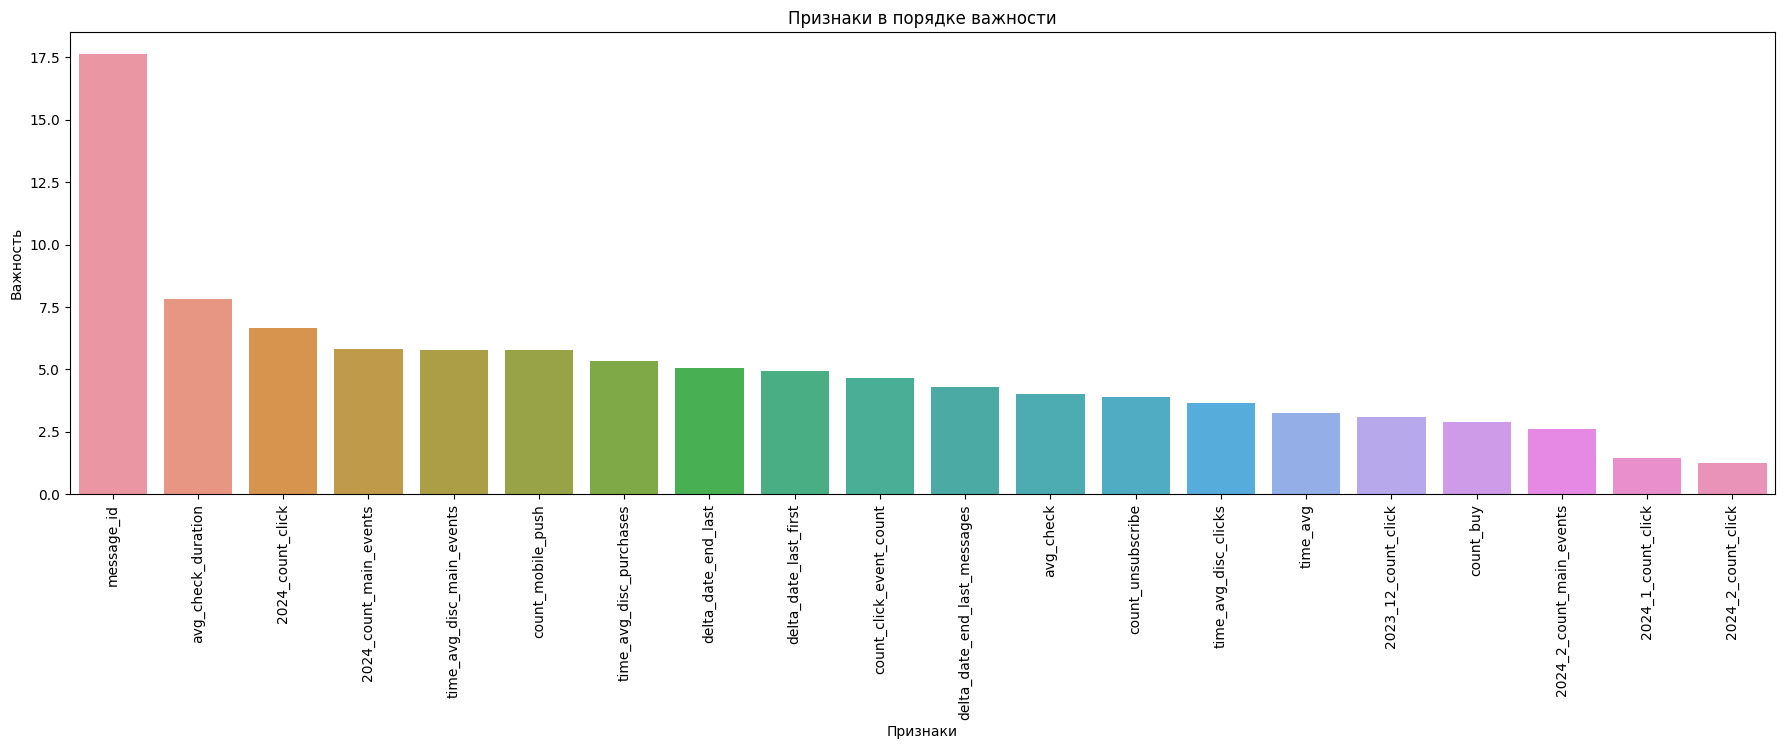

In [188]:
plt.figure(figsize=(22,6))
sns.barplot(data=df_feature_importance, x=df_feature_importance['Feature Id'], y=df_feature_importance['Importances'])
plt.xticks(rotation=90);
plt.title('Признаки в порядке важности');
plt.xlabel('Признаки');
plt.ylabel('Важность');

**Посмотрим на важность признаков, используя SHAP.**

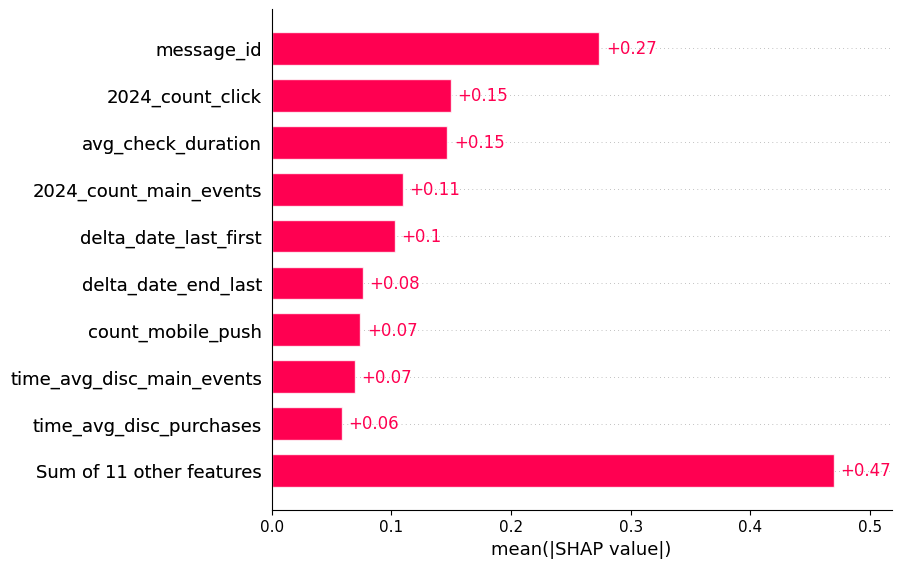

In [189]:
import shap
shap.initjs() # для красивой визуализации shap
# инициализация объекта
#explainer = shap.TreeExplainer(model_cbr, X_val, feature_perturbation="tree_path_dependent")
explainer = shap.TreeExplainer(model_cbr,feature_perturbation="tree_path_dependent")
# вычисление значений Шепли для тестовой выборки
shap_values_test = explainer(X_val)
shap.plots.bar(shap_values_test)

**Наиболее важные признаки:** идентификатор рассылки, количество кликов в 2024 году, произведение среднего чека на продолжительность между последней и первой датами покупок, количество важных событий (open, click, purchase) в 2024 году, разница между последней и первой датами покупок, разница между датой выгрузки и последней датой покупки, количество каналов mobile_push, средневзвешенный дисконтированный срок, где в качестве весов выступают суммы важных событий (open, click, purchase), средневзвешенный дисконтированный срок с весами в виде количества покупок.

## Итоговый вывод по проекту

**Видим, что наиболее важные признаки для модели - идентификатор сообщения, временные признаки, признаки с количеством событий, количеством каналов, средний чек, средневзвешенный срок. Значит будем создавать далее для улучшения модели признаки в этом направлении.**

**По техническому заданию требуется разработать модель, которая определит вероятность покупательской активности клиента, на основе которой можно определить класс покупательской активности  (не купит / купит).**   

* В основных данных приводится информация об  истории покупок,  истории рекламных рассылок, разметка с классом покупателя,  агрегация общей базы рассылок по дням и типам событий, агрегация по дням с учетом событий и каналов рассылки. Исходные данные не содержат пропусков. Дубликаты строк в таблицах с покупками и рассылками были удалены. Идентификаторы товаров обработаны: были выделены категории первого уровня, а также категории первых двух уровней и остальных уровней.   
* Анализ данных показал, что в среднем клиент тратит меньше денег на покупки со вторника по четверг, сумма покупки растет с пятницы по понедельник. Наиболее покупаемой является категория 4 для первого уровня, затем 2, 5562. В разрезе каналов рассылки доля класса 1 через mobile_push чуть выше по сравнению с email. Клиенты класса 1 имеют чуть выше долю событий: subscribe, click, open, purchase. Это говорит о необходимости создания синтетических признаков на основе каналов рассылки и действий с сообщениями.   
* Данные представлены таблицами разных форматов. Таблицы были объединены с учетом данных, по которым производилась разметка. В результате данные были агрегированы по колонке с идентификатором клиента и созданием новых дополительных агрегированных признаков на основе исходных. В результате объединения образовавшиеся пропуски были заполнены пустым значением и нулем.
* При объединении таблиц были созданы следующие агрегирующие данные по каждому клиенту: первоначальная дата покупки, последняя дата покупки, общая сумма покупки, количество уникальных категорий первого уровня для клиента, количество и сумма покупок в разрезе месяцев и лет, а также количество и сумма покупок в разрезе категорий первого уровня, первых двух уровней, наиболее частый день покупки для каждого клиента, наиболее частые идентификаторы сообщений для определенного клиента, а также идентификатор рассылки. Для каждого клиента также были получены количество каналов email и mobile_push, а также количество различных действий с сообщениями.
* Корреляционный анализ с ипсользованием phik показал, что показатели со сроками и количествами различных событий более остальных влияют на целевую переменную, не считая идентификатора сообщений, что определило создания синтетических столбцов на их основе.   
* Были созданы синтетические столбцы со средневзвешенными сроками: обычным и дисконтированным. В качестве весов взяты суммы покупок по месяцам. Для средневзвешенных дисконтированных сроков использовался приближенный расчет. В качестве ставки дисконтирования взята ставка 1% за месяц. Здесь является открытым вопрос выбора ставки дисконтирования. В теории ее принимают равной безрисковой ставке плюс поправка за риск (значение выбирается также с учетом периода времени - год, месяц).
*   При моделировании вероятности класса клиента использовался CatBoostClassifier. В классах имеется сильный дисбаланс (не купят - 98%, купят - 2%). Обычно в таких задачах используют метрику f1, так как эта метрика учитывает дисбаланс классов (является средним гармоническим между precision и recall, то есть ближе к меньшему из них). По техническому заданию требуется использовать метрику roc_auc, которая определяет производительность модели при различных пороговых значениях. Однако в случае дисбаланса данная метрика редко используется, так как может маскировать низкую эффективность модели.
*   roc_auc на валидационной выборке 0.82, на тестовой - 0.83.
*   Анализ важности признаков показал, что наиболее сильное влияние на предсказание модели оказывают: идентификатор рассылки, количество кликов в 2024 году, произведение среднего чека на продолжительность между последней и первой датами покупок, разница между последней и первой датами покупок, количество важных событий (open, click, purchase) в 2024 году, разница между датой выгрузки и последней датой покупки, количество каналов mobile_push, средневзвешенный дисконтированный срок, где в качестве весов выступают суммы важных событий (open, click, purchase), средневзвешенный дисконтированный срок с весами в виде количества покупок.
*   На основе модели можно определить класс покупателя, что может помочь бинесу для оптимизации процессов работы с покупателями.

PS: Я рассматривала и другие модели (LGBMClassifier, RandomForestClassifier, LogisticRegression). Но в работе отразила только лучшие результаты. Поиск гиперпараметров делала для себя, занимает большие временные издержки. Поэтому в работе не отражен.

In [190]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
